# 1: Imports and Setup

In [1]:

import os
import sys
import json
import gc
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import torch_geometric
from pathlib import Path
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to the Python path
# This allows importing the gnn_dta_mtl package
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

# Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:1' if torch.cuda.device_count() > 1 else 'cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

# Import your package - use absolute import instead of relative
from gnn_dta_mtl import (
    MTL_DTAModel, DTAModel,
    MTL_DTA, DTA,
    CrossValidator, MTLTrainer,
    StructureStandardizer, StructureProcessor, StructureChunkLoader,
    ESMEmbedder,
    add_molecular_properties_parallel,
    compute_ligand_efficiency,
    compute_mean_ligand_efficiency,
    filter_by_properties,
    prepare_mtl_experiment,
    build_mtl_dataset, build_mtl_dataset_optimized,
    evaluate_model,
    plot_results, plot_predictions, create_summary_report,
    ExperimentLogger,
    save_model, save_results, create_output_dir
)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Using device: cuda:1
GPU: NVIDIA A100-SXM4-40GB
Number of GPUs: 16


# 2: Configuration


In [2]:
import os
import json
from pathlib import Path
from datetime import datetime

# Create necessary directories first
base_dirs = [
    '../input/combined',
    '../input/chunk',
    '../input/embeddings',
    '../output/protein',
    '../output/ligand',
    '../output/experiments',
]

for dir_path in base_dirs:
    Path(dir_path).mkdir(parents=True, exist_ok=True)
    print(f"✓ Created: {dir_path}")

CONFIG = {
    # Data paths
    'data_path': '../input/combined/df_combined.parquet',
    'protein_out_dir': '../output/protein',
    'ligand_out_dir': '../output/ligand',
    'structure_chunks_dir': '../input/chunk/',
    'embeddings_dir': '../input/embeddings/',
    'output_dir': '../output/experiments/',
    
    # Task configuration
    'task_cols': ['pKi', 'pEC50', 'pKd (Wang, FEP)', 'pKd', 'pIC50', 'potency'],
    
    # Model configuration
    'model_config': {
        'prot_emb_dim': 1280,
        'prot_gcn_dims': [128, 256, 256],
        'prot_fc_dims': [1024, 128],
        'drug_node_in_dim': [66, 1],
        'drug_node_h_dims': [128, 64],
        'drug_edge_in_dim': [16, 1],
        'drug_edge_h_dims': [32, 1],
        'drug_fc_dims': [1024, 128],
        'mlp_dims': [1024, 512],
        'mlp_dropout': 0.25
    },
    
    # Training configuration
    'training_config': {
        'batch_size': 256,
        'n_epochs': 200,
        'learning_rate': 0.0001, # 0.0001
        'patience': 100,
        'n_folds': 5
    },
    
    # Data filtering
    'filter_config': {
        'min_heavy_atoms': 5,
        'max_heavy_atoms': 75,
        'max_mw': 1000,
        'min_carbons': 4,
        'min_le': 0.05,
        'max_le_norm': 0.003
    },
    
    # Processing
    'n_workers': os.cpu_count() - 1 if os.cpu_count() else 8,
    'chunk_size': 100000,
    'sample_size': None,  # Set to integer to limit data size for testing
    
    # ESM model
    'esm_model_name':'facebook/esm2_t33_650M_UR50D'
}

# Create experiment directory with timestamp
experiment_name = 'gnn_dta_mtl_experiment'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_dir = Path(CONFIG['output_dir']) / f"{experiment_name}_{timestamp}"

# Create subdirectories
(experiment_dir / 'models').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'results').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'figures').mkdir(parents=True, exist_ok=True)
(experiment_dir / 'logs').mkdir(parents=True, exist_ok=True)

CONFIG['experiment_dir'] = str(experiment_dir)

# Save configuration
config_path = experiment_dir / 'config.json'
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)

print(f"✓ Experiment directory: {CONFIG['experiment_dir']}")
print(f"✓ Configuration saved to: {config_path}")

✓ Created: ../input/combined
✓ Created: ../input/chunk
✓ Created: ../input/embeddings
✓ Created: ../output/protein
✓ Created: ../output/ligand
✓ Created: ../output/experiments
✓ Experiment directory: ../output/experiments/gnn_dta_mtl_experiment_20251002_150700
✓ Configuration saved to: ../output/experiments/gnn_dta_mtl_experiment_20251002_150700/config.json


# 3 : Prepare MTL Experiment

In [3]:
df = pd.read_parquet("./binding_set.parquet")

In [4]:
df.head().style

,protein_pdb_path,ligand_sdf_path,smiles,pKi,source_file,is_experimental,resolution,pEC50,"pKd (Wang, FEP)",pKd,pIC50,SMILES,potency,assay,standardized_protein_pdb,standardized_ligand_sdf,std_smiles,protein_id,InChIKey,MolWt,HeavyAtomCount,QED,NumHDonors,NumHAcceptors,NumRotatableBonds,TPSA,LogP,LE_pKi,LEnorm_pKi,LE_pEC50,LEnorm_pEC50,"LE_pKd (Wang, FEP)","LEnorm_pKd (Wang, FEP)",LE_pKd,LEnorm_pKd,LE_pIC50,LEnorm_pIC50,LE_potency,LEnorm_potency,LE,LE_norm,carbon_count
0,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL60581/protein.pdb,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL60581/ligand.sdf,CCCCCCSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O,3.259637,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None,./output/proteins/0.pdb,./output/ligands/0.sdf,CCCCCCSCC(NC(=O)CCC([NH3+])C(=O)[O-])C(=O)NCCC(=O)[O-],0,RILVFYFKIDXJNY-UHFFFAOYSA-M,404.509000,27,0.233282,3,7,16,166.100000,-2.818500,0.120727,0.000298,nan,nan,nan,nan,nan,nan,nan,nan,None,None,0.120727,0.000298,17
1,../data/raw/BindingNetv2/moderate/target_CHEMBL3902/CHEMBL58951/protein.pdb,../data/raw/BindingNetv2/moderate/target_CHEMBL3902/CHEMBL58951/ligand.sdf,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NC(C(=O)O)c1ccccc1)C(=O)O,6.376751,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None,./output/proteins/1.pdb,./output/ligands/1.sdf,[NH3+]C(CCC(=O)NC(CSCc1ccccc1)C(=O)NC(C(=O)[O-])c1ccccc1)C(=O)[O-],1,ZPSKWMFLCHMEOY-UHFFFAOYSA-M,472.543000,33,0.307698,3,7,13,166.100000,-1.847400,0.193235,0.000409,nan,nan,nan,nan,nan,nan,nan,nan,None,None,0.193235,0.000409,23
2,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL301229/protein.pdb,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL301229/ligand.sdf,Cc1ccc(CSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O)cc1,4.397940,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None,./output/proteins/2.pdb,./output/ligands/2.sdf,Cc1ccc(CSCC(NC(=O)CCC([NH3+])C(=O)[O-])C(=O)NCCC(=O)[O-])cc1,2,MBXWAPNNAOGFPH-UHFFFAOYSA-M,424.499000,29,0.305487,3,7,13,166.100000,-2.890180,0.151653,0.000357,nan,nan,nan,nan,nan,nan,nan,nan,None,None,0.151653,0.000357,19
3,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL442360/protein.pdb,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL442360/ligand.sdf,NC(CCC(=O)NC(CSCc1ccc(Cl)cc1)C(=O)NC(C(=O)O)c1ccccc1)C(=O)O,6.920819,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None,./output/proteins/3.pdb,./output/ligands/3.sdf,[NH3+]C(CCC(=O)NC(CSCc1ccc(Cl)cc1)C(=O)NC(C(=O)[O-])c1ccccc1)C(=O)[O-],3,BXJSPWKYSSRFEB-UHFFFAOYSA-M,506.988000,34,0.306713,3,7,13,166.100000,-1.194000,0.203553,0.000401,nan,nan,nan,nan,nan,nan,nan,nan,None,None,0.203553,0.000401,24
4,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL58451/protein.pdb,../data/raw/BindingNetv2/high/target_CHEMBL3902/CHEMBL58451/ligand.sdf,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NCCC(=O)O)C(=O)O,3.148742,BindingNetv2,False,nan,nan,nan,nan,nan,None,nan,None,./output/proteins/4.pdb,./output/ligands/4.sdf,[NH3+]C(CCC(=O)NC(CSCc1ccccc1)C(=O)NCCC(=O)[O-])C(=O)[O-],4,QLVGMERIDWMEBM-UHFFFAOYSA-M,410.472000,28,0.307814,3,7,13,166.100000,-3.198600,0.112455,0.000274,nan,nan,nan,nan,nan,nan,nan,nan,None,None,0.112455,0.000274,18


In [ ]:
len(df)

# Drop duplicates

In [18]:
import pandas as pd
import numpy as np
from Bio import PDB
from Bio.PDB import PDBParser
from collections import Counter, defaultdict
from multiprocessing import Pool, cpu_count
from functools import partial
import warnings
from tqdm import tqdm
import hashlib
warnings.filterwarnings('ignore')

# ============================================================================
# PARALLEL PDB PROCESSING FUNCTIONS
# ============================================================================

def extract_sequence_from_pdb_single(pdb_path):
    """
    Extract sequences from a single PDB file for each chain.
    This function is designed to be run in parallel.
    
    Returns: (pdb_path, list of sequences)
    """
    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure('protein', pdb_path)
        
        sequences = []
        for model in structure:
            for chain in model:
                seq = []
                for residue in chain:
                    if PDB.is_aa(residue):
                        res_name = residue.get_resname()
                        # Convert 3-letter code to 1-letter code
                        three_to_one = {
                            'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E',
                            'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
                            'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
                            'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S',
                            'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
                        }
                        if res_name in three_to_one:
                            seq.append(three_to_one[res_name])
                
                if seq:
                    sequences.append(''.join(seq))
        
        return (pdb_path, sequences)
    except Exception as e:
        print(f"Error processing {pdb_path}: {e}")
        return (pdb_path, [])

def parallel_extract_pdb_sequences(pdb_paths, n_workers=None):
    """
    Extract sequences from multiple PDB files in parallel.
    
    Args:
        pdb_paths: List of PDB file paths
        n_workers: Number of parallel workers (None = use all CPUs)
    
    Returns:
        Dictionary mapping pdb_path to sequences
    """
    if n_workers is None:
        n_workers = cpu_count()
    
    print(f"Processing {len(pdb_paths)} PDB files with {n_workers} workers...")
    
    with Pool(n_workers) as pool:
        results = list(tqdm(
            pool.imap(extract_sequence_from_pdb_single, pdb_paths),
            total=len(pdb_paths),
            desc="Extracting PDB sequences"
        ))
    
    # Convert results to dictionary
    pdb_to_sequences = {pdb_path: sequences for pdb_path, sequences in results}
    return pdb_to_sequences

def create_global_sequence_mapping(pdb_to_sequences):
    """
    Create a global mapping of sequences to IDs across all PDBs.
    
    Args:
        pdb_to_sequences: Dictionary mapping PDB paths to their sequences
    
    Returns:
        seq_to_id: Dictionary mapping sequences to IDs
        id_to_seq: Dictionary mapping IDs to sequences
    """
    seq_to_id = {}
    id_to_seq = {}
    
    # Collect all unique sequences
    all_sequences = set()
    for sequences in pdb_to_sequences.values():
        all_sequences.update(sequences)
    
    # Assign IDs to unique sequences
    for i, seq in enumerate(sorted(all_sequences)):
        if i < 26:
            seq_id = chr(65 + i)  # A, B, C, ...
        else:
            # Use two letters for more than 26 sequences
            seq_id = f"{chr(65 + (i // 26 - 1))}{chr(65 + (i % 26))}"
        
        seq_to_id[seq] = seq_id
        id_to_seq[seq_id] = seq
    
    return seq_to_id, id_to_seq

def create_sequence_id_for_pdb(sequences, seq_to_id):
    """
    Create a sequence ID string for a PDB based on its sequences.
    E.g., "2A4B" means 2 of sequence A and 4 of sequence B
    """
    if not sequences:
        return "EMPTY"
    
    # Count occurrences of each sequence
    seq_counter = Counter(sequences)
    
    # Map sequences to IDs and count them
    id_counts = defaultdict(int)
    for seq, count in seq_counter.items():
        if seq in seq_to_id:
            id_counts[seq_to_id[seq]] += count
    
    # Create the ID string (alphabetically sorted)
    id_string = ''
    for seq_id in sorted(id_counts.keys()):
        count = id_counts[seq_id]
        if count == 1:
            id_string += seq_id
        else:
            id_string += f"{count}{seq_id}"
    
    return id_string

# ============================================================================
# PARALLEL INCHIKEY PROCESSING FUNCTIONS
# ============================================================================

def process_inchikey_batch(batch_data):
    """
    Process a batch of InChIKeys in parallel.
    This function can be extended to perform additional InChIKey processing.
    
    Args:
        batch_data: Tuple of (indices, inchikeys, smiles)
    
    Returns:
        List of tuples (index, processed_inchikey, additional_data)
    """
    indices, inchikeys, smiles = batch_data
    results = []
    
    for idx, inchikey, smile in zip(indices, inchikeys, smiles):
        # Here you can add more complex InChIKey processing
        # For now, we just validate and potentially standardize
        processed_inchikey = inchikey if pd.notna(inchikey) else f"UNKNOWN_{idx}"
        
        # You can add molecular property calculations here
        additional_data = {
            'inchikey_hash': hashlib.md5(str(inchikey).encode()).hexdigest()[:8],
            'has_valid_inchikey': pd.notna(inchikey)
        }
        
        results.append((idx, processed_inchikey, additional_data))
    
    return results

def parallel_process_inchikeys(df, n_workers=None, batch_size=10000):
    """
    Process InChIKeys in parallel batches.
    
    Args:
        df: DataFrame containing InChIKey column
        n_workers: Number of parallel workers
        batch_size: Size of each processing batch
    
    Returns:
        DataFrame with processed InChIKey information
    """
    if n_workers is None:
        n_workers = cpu_count()
    
    print(f"Processing {len(df)} InChIKeys with {n_workers} workers...")
    
    # Create batches
    batches = []
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batches.append((
            batch_df.index.tolist(),
            batch_df['InChIKey'].tolist(),
            batch_df['std_smiles'].tolist() if 'std_smiles' in df.columns else [None] * len(batch_df)
        ))
    
    # Process batches in parallel
    with Pool(n_workers) as pool:
        batch_results = list(tqdm(
            pool.imap(process_inchikey_batch, batches),
            total=len(batches),
            desc="Processing InChIKeys"
        ))
    
    # Flatten results and create mapping
    all_results = []
    for batch_result in batch_results:
        all_results.extend(batch_result)
    
    # Sort by index to maintain order
    all_results.sort(key=lambda x: x[0])
    
    # Add results to dataframe
    for idx, processed_inchikey, additional_data in all_results:
        df.loc[idx, 'processed_inchikey'] = processed_inchikey
        for key, value in additional_data.items():
            df.loc[idx, key] = value
    
    return df

# ============================================================================
# PARALLEL DEDUPLICATION FUNCTIONS
# ============================================================================

def process_duplicate_group(group_data, response_cols, priority_func):
    """
    Process a single group of duplicate complexes.
    
    Args:
        group_data: Tuple of (complex_id, group_dataframe)
        response_cols: List of response column names
        priority_func: Function to calculate priority
    
    Returns:
        Processed row as dictionary
    """
    complex_id, group = group_data
    
    if len(group) == 1:
        # No duplicates, keep as is
        row_dict = group.iloc[0].to_dict()
        row_dict['num_merged'] = 1
        return row_dict
    else:
        # Multiple rows for same complex
        group = group.copy()
        group['priority'] = group['source_file'].apply(priority_func)
        group = group.sort_values('priority')
        
        # Take the row with highest priority as base
        best_row = group.iloc[0].to_dict()
        
        # Merge response values from all rows in the group
        for col in response_cols:
            values = group[col].dropna().values
            
            if len(values) == 0:
                best_row[col] = np.nan
            elif len(values) == 1:
                best_row[col] = values[0]
            elif len(values) == 2:
                best_row[col] = min(values)
            else:  # 3 or more values
                best_row[col] = np.median(values)
        
        # Add merge information
        best_row['merged_from_sources'] = ','.join(group['source_file'].unique())
        best_row['num_merged'] = len(group)
        
        return best_row

def parallel_remove_duplicates(df, n_workers=None):
    """
    Remove duplicates iteratively based on complex (protein+ligand).
    Creates and returns a new dataframe without modifying the original.
    
    Args:
        df: DataFrame with sequence_id and InChIKey columns
    
    Returns:
        result_df: New deduplicated DataFrame
    """
    # Create a copy to avoid modifying original
    df_copy = df.copy()
    
    # Define response value columns
    response_cols = ['pKd (Wang, FEP)', 'pKd', 'pIC50', 'pEC50', 'pKi'] # ['pKd (Wang, FEP)', 'pKd', 'pIC50', 'potency', 'pEC50', 'pKi']
    
    # Create complex identifier
    df_copy['complex_id'] = df_copy['InChIKey'] + '_' + df_copy['sequence_id']
    
    # Group by complex_id
    grouped = df_copy.groupby('complex_id')
    
    print(f"Processing {len(grouped)} unique complexes...")
    
    # Define priority function
    def get_priority(source):
        priority_map = {
            'PDBbind2020': 1,
            'FEP_Wang_2015': 2,
            'FEP_Zariquiey_extended_Wang_2015': 3,
            'HiQBind': 4,
            'BioLip2': 5,
            'processed_data': 6,
            'BindingNetv2': 7,
            'BindingNetv1': 8
        }
        return priority_map.get(source, 999)
    
    # Function to merge response values
    def merge_response_values(group, response_cols):
        """
        Merge response values from a group of duplicate rows.
        For each response type, select median if >=3 datapoints, else minimum.
        """
        merged = {}
        
        for col in response_cols:
            # Collect non-NaN values for this response type
            values = group[col].dropna().values
            
            if len(values) == 0:
                merged[col] = np.nan
            elif len(values) == 1:
                merged[col] = values[0]
            elif len(values) == 2:
                merged[col] = min(values)
            else:  # 3 or more values
                merged[col] = np.median(values)
        
        return merged
    
    # List to store processed rows
    result_rows = []
    
    # Iterate through each group
    for complex_id, group in tqdm(grouped, desc="Deduplicating complexes"):
        if len(group) == 1:
            # No duplicates, keep as is
            row_dict = group.iloc[0].to_dict()
            row_dict['num_merged'] = 1
            row_dict.pop('complex_id', None)  # Remove complex_id from result
            result_rows.append(row_dict)
        else:
            # Multiple rows for same complex
            # Create a copy of the group to avoid warnings
            group = group.copy()
            
            # Add priority column
            group['priority'] = group['source_file'].apply(get_priority)
            
            # Sort by priority (lowest number = highest priority)
            group = group.sort_values('priority')
            
            # Take the row with highest priority as base
            best_row = group.iloc[0].to_dict()
            
            # Merge response values from all rows in the group
            merged_values = merge_response_values(group, response_cols)
            
            # Update the best row with merged values
            for col, value in merged_values.items():
                best_row[col] = value
            
            # Add merge information
            best_row['merged_from_sources'] = ','.join(group['source_file'].unique())
            best_row['num_merged'] = len(group)
            
            # Remove temporary columns
            best_row.pop('priority', None)
            best_row.pop('complex_id', None)
            
            result_rows.append(best_row)
    
    # Create new dataframe from results
    result_df = pd.DataFrame(result_rows)
    
    # Ensure column order matches original (plus new columns)
    original_cols = [col for col in df.columns if col in result_df.columns]
    new_cols = [col for col in result_df.columns if col not in df.columns]
    result_df = result_df[original_cols + new_cols]
    
    print(f"Deduplication complete: {len(df)} -> {len(result_df)} rows")
    print(f"Removed {len(df) - len(result_df)} duplicate rows ({(1 - len(result_df)/len(df))*100:.2f}% reduction)")
    
    return result_df

# ============================================================================
# MAIN PIPELINE FUNCTION
# ============================================================================



# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def print_summary_statistics(original_df, final_df):
    """
    Print detailed summary statistics about the deduplication process.
    """
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    print(f"\nOriginal dataset:")
    print(f"  - Total rows: {len(original_df):,}")
    print(f"  - Unique proteins: {original_df['standardized_protein_pdb'].nunique():,}")
    print(f"  - Unique ligands: {original_df['InChIKey'].nunique():,}")
    
    print(f"\nProcessed dataset:")
    print(f"  - Total rows: {len(final_df):,}")
    print(f"  - Rows removed: {len(original_df) - len(final_df):,}")
    print(f"  - Reduction: {(1 - len(final_df)/len(original_df))*100:.2f}%")
    
    if 'num_merged' in final_df.columns:
        merged_stats = final_df['num_merged'].value_counts().sort_index()
        print(f"\nMerging statistics:")
        for num, count in merged_stats.items():
            print(f"  - {count:,} complexes {'kept as-is' if num == 1 else f'merged from {num} sources'}")
    
    print("\nResponse value coverage:")
    response_cols = ['pKd (Wang, FEP)', 'pKd', 'pIC50','pEC50', 'pKi'] # ['pKd (Wang, FEP)', 'pKd', 'pIC50', 'potency', 'pEC50', 'pKi']
    for col in response_cols:
        if col in final_df.columns:
            coverage = (final_df[col].notna().sum() / len(final_df)) * 100
            print(f"  - {col}: {coverage:.2f}% coverage ({final_df[col].notna().sum():,} values)")
    
    print("\n" + "="*60)

# ============================================================================
# EXAMPLE USAGE
# ============================================================================



In [ ]:
### print("="*60)
print("STARTING PARALLEL PROCESSING PIPELINE")
print("="*60)
print(f"Initial dataframe shape: {df.shape}")
# Step 1: Parallel PDB sequence extraction
print("\n" + "="*60)
print("STEP 1: PARALLEL PDB SEQUENCE EXTRACTION")
print("="*60)
pdb_paths = df['standardized_protein_pdb'].unique().tolist()
pdb_to_sequences = parallel_extract_pdb_sequences(pdb_paths, cpu_count())


In [ ]:
# Create global sequence mapping
seq_to_id, id_to_seq = create_global_sequence_mapping(pdb_to_sequences)
print(f"Found {len(seq_to_id)} unique protein sequences")
# Apply sequence IDs to dataframe
sequence_ids = []
for _, row in tqdm(df.iterrows()):
    pdb_path = row['standardized_protein_pdb']
    sequences = pdb_to_sequences.get(pdb_path, [])
    seq_id = create_sequence_id_for_pdb(sequences, seq_to_id)
    sequence_ids.append(seq_id)
df['sequence_id'] = sequence_ids
# Create sequence mapping dataframe
seq_mapping = pd.DataFrame([
    {'sequence_id': sid, 'sequence': seq} 
    for sid, seq in id_to_seq.items()
])


In [ ]:
# Step 2: Parallel InChIKey processing
print("\n" + "="*60)
print("STEP 2: PARALLEL INCHIKEY PROCESSING")
print("="*60)
df = parallel_process_inchikeys(df, cpu_count())
# Step 3: Parallel deduplication
print("\n" + "="*60)
print("STEP 3: PARALLEL DEDUPLICATION")
print("="*60)


In [17]:
df

,protein_pdb_path,ligand_sdf_path,smiles,pKi,source_file,is_experimental,resolution,pEC50,"pKd (Wang, FEP)",pKd,...,LE_potency,LEnorm_potency,LE,LE_norm,carbon_count,sequence_id,processed_inchikey,inchikey_hash,has_valid_inchikey,complex_id
0,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,CCCCCCSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O,3.259637,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,None,0.120727,0.000298,17,2ƘC,RILVFYFKIDXJNY-UHFFFAOYSA-M,2f8150df,True,RILVFYFKIDXJNY-UHFFFAOYSA-M_2ƘC
1,../data/raw/BindingNetv2/moderate/target_CHEMB...,../data/raw/BindingNetv2/moderate/target_CHEMB...,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NC(C(=O)O)c1cccc...,6.376751,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,None,0.193235,0.000409,23,2ƘC,ZPSKWMFLCHMEOY-UHFFFAOYSA-M,71a014c7,True,ZPSKWMFLCHMEOY-UHFFFAOYSA-M_2ƘC
2,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,Cc1ccc(CSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCCC(=O)O)cc1,4.397940,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,None,0.151653,0.000357,19,2ƉY,MBXWAPNNAOGFPH-UHFFFAOYSA-M,1cba16d5,True,MBXWAPNNAOGFPH-UHFFFAOYSA-M_2ƉY
3,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,NC(CCC(=O)NC(CSCc1ccc(Cl)cc1)C(=O)NC(C(=O)O)c1...,6.920819,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,None,0.203553,0.000401,24,2ƘC,BXJSPWKYSSRFEB-UHFFFAOYSA-M,a823c50d,True,BXJSPWKYSSRFEB-UHFFFAOYSA-M_2ƘC
4,../data/raw/BindingNetv2/high/target_CHEMBL390...,../data/raw/BindingNetv2/high/target_CHEMBL390...,NC(CCC(=O)NC(CSCc1ccccc1)C(=O)NCCC(=O)O)C(=O)O,3.148742,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,None,0.112455,0.000274,18,2ŘN,QLVGMERIDWMEBM-UHFFFAOYSA-M,46313ec9,True,QLVGMERIDWMEBM-UHFFFAOYSA-M_2ŘN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406083,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,CC1CCCC(N2NC(C(C)(C)C)C[C@@H]2N[C@@H](O)NC2CCC...,NaN,BioLip2,True,NaN,NaN,NaN,7.130768,...,None,None,0.187652,0.000351,29,¦Q,NACQWABIDVXOMV-VFCRXLDWSA-N,b325f1a8,True,NACQWABIDVXOMV-VFCRXLDWSA-N_¦Q
406084,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,OC[C@H]1O[C@H](O[PH](O)(O)O[PH](O)(O)OC[C@H]2O...,NaN,BioLip2,True,NaN,NaN,NaN,3.124939,...,None,None,0.086804,0.000151,15,ĔV,PEEYOHTXAULSGT-KPLOLNPKSA-N,ba696fe5,True,PEEYOHTXAULSGT-KPLOLNPKSA-N_ĔV
406085,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,C[C@H]1S[C@H]2NC(N)N[C@@H](O)[C@@H]2C1SC1CCC(C...,NaN,BioLip2,True,NaN,NaN,NaN,7.698970,...,None,None,0.248354,0.000515,19,ȚS,VYTCQXDFOQVDLB-WZBLSFTPSA-N,3c3e05eb,True,VYTCQXDFOQVDLB-WZBLSFTPSA-N_ȚS
406086,../data/raw/BioLip2/biolip_downloads/biolip_re...,../data/raw/BioLip2/biolip_downloads/biolip_re...,CCCCCCC1CCC(C(O)NNC(S)NC)O1,NaN,BioLip2,True,NaN,NaN,NaN,4.096910,...,None,None,0.215627,0.000740,13,ǋO,QDYXIFNPTRANPQ-UHFFFAOYSA-N,217020ae,True,QDYXIFNPTRANPQ-UHFFFAOYSA-N_ǋO


In [19]:
final_df = parallel_remove_duplicates(df, cpu_count())
print("\n" + "="*60)
print("PROCESSING COMPLETE")
print("="*60)
print(f"Final dataframe shape: {final_df.shape}")
print(f"Removed {len(df) - len(final_df)} duplicate rows")
print(f"Reduction: {(1 - len(final_df)/len(df))*100:.2f}%")


Processing 395836 unique complexes...


Deduplicating complexes: 100%|██████████| 395836/395836 [01:30<00:00, 4389.68it/s]


Deduplication complete: 406088 -> 395836 rows
Removed 10252 duplicate rows (2.52% reduction)

PROCESSING COMPLETE
Final dataframe shape: (395836, 48)
Removed 10252 duplicate rows
Reduction: 2.52%


In [21]:
print_summary_statistics(df, final_df)

final_df.to_csv('deduplicated_complexes_parallel.csv', index=False)
seq_mapping.to_csv('sequence_mapping.csv', index=False)
    
print("Pipeline loaded successfully!")
print("To use: final_df, seq_mapping = process_dataframe_parallel(df)")


SUMMARY STATISTICS

Original dataset:
  - Total rows: 406,088
  - Unique proteins: 406,088
  - Unique ligands: 306,191

Processed dataset:
  - Total rows: 395,836
  - Rows removed: 10,252
  - Reduction: 2.52%

Merging statistics:
  - 388,888 complexes kept as-is
  - 5,986 complexes merged from 2 sources
  - 558 complexes merged from 3 sources
  - 185 complexes merged from 4 sources
  - 40 complexes merged from 5 sources
  - 40 complexes merged from 6 sources
  - 18 complexes merged from 7 sources
  - 24 complexes merged from 8 sources
  - 15 complexes merged from 9 sources
  - 6 complexes merged from 10 sources
  - 2 complexes merged from 11 sources
  - 12 complexes merged from 12 sources
  - 9 complexes merged from 13 sources
  - 7 complexes merged from 14 sources
  - 2 complexes merged from 15 sources
  - 2 complexes merged from 16 sources
  - 5 complexes merged from 17 sources
  - 2 complexes merged from 18 sources
  - 2 complexes merged from 19 sources
  - 1 complexes merged from 

NameError: name 'seq_mapping' is not defined

In [24]:
final_df

,protein_pdb_path,ligand_sdf_path,smiles,pKi,source_file,is_experimental,resolution,pEC50,"pKd (Wang, FEP)",pKd,...,LEnorm_potency,LE,LE_norm,carbon_count,sequence_id,processed_inchikey,inchikey_hash,has_valid_inchikey,num_merged,merged_from_sources
0,../data/raw/BindingNetv2/moderate/target_CHEMB...,../data/raw/BindingNetv2/moderate/target_CHEMB...,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,0.167298,0.000272,33,QS,AAAAZQPHATYWOK-JXMROGBWSA-O,4f129304,True,1,NaN
1,../data/raw/BindingNetv2/moderate/target_CHEMB...,../data/raw/BindingNetv2/moderate/target_CHEMB...,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,0.156415,0.000255,33,ãK,AAAAZQPHATYWOK-JXMROGBWSA-O,4f129304,True,1,NaN
2,../data/raw/BindingNetv2/high/target_CHEMBL258...,../data/raw/BindingNetv2/high/target_CHEMBL258...,Cc1ccc(O)cc1Nc1cc(N2CCOCC2)nc(-n2cnc3ccccc32)n1,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,0.228776,0.000568,22,ȭG,AAABTPAECTZDET-UHFFFAOYSA-N,62568322,True,1,NaN
3,../data/raw/BindingNetv2/high/target_CHEMBL297...,../data/raw/BindingNetv2/high/target_CHEMBL297...,COC(=O)C[C@@H](NC(=O)c1ccc(-c2cn[nH]c2)c(C)c1)...,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,0.264950,0.000729,21,ǱN,AAACGYYPWMUUFL-LJQANCHMSA-N,b8ce4f00,True,1,NaN
4,../data/raw/BindingNetv2/high/target_CHEMBL323...,../data/raw/BindingNetv2/high/target_CHEMBL323...,COC(=O)C[C@@H](NC(=O)c1ccc(-c2cn[nH]c2)c(C)c1)...,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,None,0.236761,0.000651,21,ȍV,AAACGYYPWMUUFL-LJQANCHMSA-N,b8ce4f00,True,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395831,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NP(=O)(O[H])O[H])N([H])C([H])([H])C([...,NaN,PDBbind2020,True,1.85,NaN,NaN,3.070581,...,None,0.191911,0.000755,6,ÆIăS,,d41d8cd9,True,1,NaN
395832,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(C2:C([H]):N:N(C([H])([H]...,6.873234,PDBbind2020,True,1.90,NaN,NaN,NaN,...,None,0.242082,0.000679,16,ôX,,d41d8cd9,True,6,PDBbind2020
395833,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(Cl):C(N2C([H])([H])C([H]...,5.867740,PDBbind2020,True,1.70,NaN,NaN,NaN,...,None,0.279416,0.000899,13,ôY,,d41d8cd9,True,2,PDBbind2020
395834,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(Cl):C(N([H])[H]):N:C:1N(...,5.275724,PDBbind2020,True,2.10,NaN,NaN,NaN,...,None,0.351715,0.001538,7,õB,,d41d8cd9,True,1,NaN


# Task range

In [5]:
df = pd.read_csv("deduplicated_complexes_parallel.csv")

In [6]:
df

,protein_pdb_path,ligand_sdf_path,smiles,pKi,source_file,is_experimental,resolution,pEC50,"pKd (Wang, FEP)",pKd,...,LEnorm_potency,LE,LE_norm,carbon_count,sequence_id,processed_inchikey,inchikey_hash,has_valid_inchikey,num_merged,merged_from_sources
0,../data/raw/BindingNetv2/moderate/target_CHEMB...,../data/raw/BindingNetv2/moderate/target_CHEMB...,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,NaN,0.167298,0.000272,33,QS,AAAAZQPHATYWOK-JXMROGBWSA-O,4f129304,True,1,NaN
1,../data/raw/BindingNetv2/moderate/target_CHEMB...,../data/raw/BindingNetv2/moderate/target_CHEMB...,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,NaN,0.156415,0.000255,33,ãK,AAAAZQPHATYWOK-JXMROGBWSA-O,4f129304,True,1,NaN
2,../data/raw/BindingNetv2/high/target_CHEMBL258...,../data/raw/BindingNetv2/high/target_CHEMBL258...,Cc1ccc(O)cc1Nc1cc(N2CCOCC2)nc(-n2cnc3ccccc32)n1,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,NaN,0.228776,0.000568,22,ȭG,AAABTPAECTZDET-UHFFFAOYSA-N,62568322,True,1,NaN
3,../data/raw/BindingNetv2/high/target_CHEMBL297...,../data/raw/BindingNetv2/high/target_CHEMBL297...,COC(=O)C[C@@H](NC(=O)c1ccc(-c2cn[nH]c2)c(C)c1)...,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,NaN,0.264950,0.000729,21,ǱN,AAACGYYPWMUUFL-LJQANCHMSA-N,b8ce4f00,True,1,NaN
4,../data/raw/BindingNetv2/high/target_CHEMBL323...,../data/raw/BindingNetv2/high/target_CHEMBL323...,COC(=O)C[C@@H](NC(=O)c1ccc(-c2cn[nH]c2)c(C)c1)...,NaN,BindingNetv2,False,NaN,NaN,NaN,NaN,...,NaN,0.236761,0.000651,21,ȍV,AAACGYYPWMUUFL-LJQANCHMSA-N,b8ce4f00,True,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395831,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NP(=O)(O[H])O[H])N([H])C([H])([H])C([...,NaN,PDBbind2020,True,1.85,NaN,NaN,3.070581,...,NaN,0.191911,0.000755,6,ÆIăS,NaN,d41d8cd9,True,1,NaN
395832,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(C2:C([H]):N:N(C([H])([H]...,6.873234,PDBbind2020,True,1.90,NaN,NaN,NaN,...,NaN,0.242082,0.000679,16,ôX,NaN,d41d8cd9,True,6,PDBbind2020
395833,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(Cl):C(N2C([H])([H])C([H]...,5.867740,PDBbind2020,True,1.70,NaN,NaN,NaN,...,NaN,0.279416,0.000899,13,ôY,NaN,d41d8cd9,True,2,PDBbind2020
395834,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(Cl):C(N([H])[H]):N:C:1N(...,5.275724,PDBbind2020,True,2.10,NaN,NaN,NaN,...,NaN,0.351715,0.001538,7,õB,NaN,d41d8cd9,True,1,NaN


In [7]:

# Calculate task ranges for weighting
task_ranges = prepare_mtl_experiment(df, CONFIG['task_cols'])

# Create task statistics
print("\nTask Statistics:")
for task in CONFIG['task_cols']:
    if task in df.columns:
        valid_values = df[task].dropna()
        if len(valid_values) > 0:
            print(f"{task}:")
            print(f"  Count: {len(valid_values)}")
            print(f"  Mean: {valid_values.mean():.2f}")
            print(f"  Std: {valid_values.std():.2f}")
            print(f"  Range: [{valid_values.min():.2f}, {valid_values.max():.2f}]")

Task ranges for weighting:
  pKi: range=10.00, weight=0.0627
  pEC50: range=9.95, weight=0.0629
  pKd (Wang, FEP): range=4.90, weight=0.1278
  pKd: range=10.92, weight=0.0574
  pIC50: range=10.00, weight=0.0627
  potency: range=1.00, weight=0.6266

Task Statistics:
pKi:
  Count: 95436
  Mean: 7.02
  Std: 1.43
  Range: [3.00, 13.00]
pEC50:
  Count: 18266
  Mean: 6.76
  Std: 1.30
  Range: [3.05, 13.00]
pKd (Wang, FEP):
  Count: 262
  Mean: 6.88
  Std: 1.00
  Range: [4.24, 9.14]
pKd:
  Count: 16114
  Mean: 6.52
  Std: 1.53
  Range: [3.00, 13.92]
pIC50:
  Count: 267096
  Mean: 6.81
  Std: 1.31
  Range: [3.00, 13.00]


In [8]:
CONFIG['structure_chunks_dir']

'../input/chunk/'

In [9]:
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')


In [10]:
CONFIG['task_cols']

['pKi', 'pEC50', 'pKd (Wang, FEP)', 'pKd', 'pIC50', 'potency']

In [11]:

# Create chunk loader
chunk_loader = StructureChunkLoader(
    chunk_dir=CONFIG['structure_chunks_dir'],
    cache_size=10
)



Loaded 406088 structures from 10 chunks


# 4 : Cross-Validation Training

In [15]:
# Cell 9: Cross-Validation Training
# Initialize cross-validator
cv = CrossValidator(
    model_config=CONFIG['model_config'],
    task_cols=CONFIG['task_cols'],
    task_ranges=task_ranges,
    n_folds=CONFIG['training_config']['n_folds'],
    batch_size=CONFIG['training_config']['batch_size'],
    n_epochs=CONFIG['training_config']['n_epochs'],
    learning_rate=CONFIG['training_config']['learning_rate'],
    patience=CONFIG['training_config']['patience'],
    device=device,
    seed=SEED
)


In [16]:

# Run cross-validation
print("\nStarting cross-validation...")
cv_results = cv.run(df, chunk_loader)



Starting cross-validation...

Starting 5-fold cross-validation...

Fold 1 sizes:
  Train: 7263
  Valid: 807
  Test:  2018
Loading structures for 7263 unique proteins...
Processing 7263 entries with 8 workers...


Building dataset:   1%|          | 89/7263 [00:01<01:43, 68.99it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 1312/7263 [00:19<01:33, 63.57it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  26%|██▋       | 1908/7263 [00:28<01:22, 64.80it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  27%|██▋       | 1991/7263 [00:30<01:18, 67.43it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  48%|████▊     | 3474/7263 [00:52<00:59, 64.12it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  60%|██████    | 4371/7263 [01:06<00:45, 64.02it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  65%|██████▌   | 4756/7263 [01:12<00:39, 63.76it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset: 100%|██████████| 7263/7263 [01:51<00:00, 65.30it/s]


Loading structures for 807 unique proteins...
Processing 807 entries with 8 workers...


Building dataset:  41%|████      | 331/807 [00:05<00:07, 63.60it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  48%|████▊     | 390/807 [00:06<00:06, 64.70it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 540/807 [00:08<00:04, 61.64it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset: 100%|██████████| 807/807 [00:12<00:00, 64.31it/s]


Loading structures for 2018 unique proteins...
Processing 2018 entries with 8 workers...


Building dataset:  66%|██████▋   | 1339/2018 [00:20<00:11, 61.13it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset: 100%|██████████| 2018/2018 [00:31<00:00, 64.52it/s]



FOLD 1/5


Evaluating: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]



Fold 2 sizes:
  Train: 7263
  Valid: 807
  Test:  2018
Loading structures for 7263 unique proteins...
Processing 7263 entries with 8 workers...


Building dataset:   1%|          | 83/7263 [00:01<01:51, 64.46it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  26%|██▌       | 1885/7263 [00:28<01:26, 62.24it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  27%|██▋       | 1966/7263 [00:29<01:24, 62.48it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  60%|██████    | 4385/7263 [01:06<00:49, 57.84it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  65%|██████▌   | 4751/7263 [01:12<00:39, 63.41it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  71%|███████   | 5172/7263 [01:18<00:34, 61.28it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset: 100%|██████████| 7263/7263 [01:51<00:00, 65.35it/s]


Loading structures for 807 unique proteins...
Processing 807 entries with 8 workers...


Building dataset:  17%|█▋        | 139/807 [00:02<00:10, 66.21it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  22%|██▏       | 177/807 [00:02<00:09, 66.89it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  89%|████████▊ | 715/807 [00:10<00:01, 65.32it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset: 100%|██████████| 807/807 [00:12<00:00, 66.58it/s]


Loading structures for 2018 unique proteins...
Processing 2018 entries with 8 workers...


Building dataset:   2%|▏         | 42/2018 [00:00<00:30, 64.60it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset: 100%|██████████| 2018/2018 [00:30<00:00, 65.63it/s]



FOLD 2/5


Evaluating: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]



Fold 3 sizes:
  Train: 7263
  Valid: 807
  Test:  2018
Loading structures for 7263 unique proteins...
Processing 7263 entries with 8 workers...


Building dataset:   1%|▏         | 99/7263 [00:01<01:51, 64.18it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  13%|█▎        | 917/7263 [00:14<01:41, 62.48it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 1328/7263 [00:20<01:31, 65.10it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  27%|██▋       | 1980/7263 [00:30<01:24, 62.71it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  65%|██████▌   | 4724/7263 [01:13<00:41, 61.92it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  81%|████████  | 5859/7263 [01:30<00:21, 64.57it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [101]:
!cp -r ../../application/VHH_model/structure_model/CD33/*  ./data/test

In [101]:
!cp -r ../../application/VHH_model/structure_model/CD33/*  ./data/test

In [75]:
# Need to clear memory between each fold

In [76]:
# 100-200 epochs

In [17]:
# Print summary
cv.print_summary()

# Save CV results
save_results(
    cv_results, 
    os.path.join(CONFIG['experiment_dir'], 'results', 'cv_results.pkl'),
    format='pickle'
)


CROSS-VALIDATION SUMMARY

pKi:
  R²:    0.601 ± 0.034
  RMSE:  1.153 ± 0.042
  Total samples: 4078

pEC50:
  R²:    0.517 ± 0.146
  RMSE:  1.056 ± 0.192
  Total samples: 224

pKd (Wang, FEP):
  R²:    0.643 ± 0.075
  RMSE:  0.583 ± 0.074
  Total samples: 262

pKd:
  R²:    0.557 ± 0.048
  RMSE:  1.179 ± 0.063
  Total samples: 3762

pIC50:
  R²:    0.525 ± 0.048
  RMSE:  1.012 ± 0.066
  Total samples: 2475
Results saved to ../output/experiments/gnn_dta_mtl_experiment_20250929_093711/results/cv_results.pkl


# 4 : Full Training on All Data

In [12]:
set(df.source_file.values)

{'BindingNetv2',
 'BioLip2',
 'FEP_Wang_2015',
 'FEP_Zariquiey_extended_Wang_2015',
 'HiQBind',
 'PDBbind2020'}

In [11]:
df = df[df['source_file'].isin(['BioLip2',
 'FEP_Wang_2015',
 'FEP_Zariquiey_extended_Wang_2015',
 'HiQBind',
 'PDBbind2020'])]

In [12]:
df

,protein_pdb_path,ligand_sdf_path,smiles,pKi,source_file,is_experimental,resolution,pEC50,"pKd (Wang, FEP)",pKd,...,LEnorm_potency,LE,LE_norm,carbon_count,sequence_id,processed_inchikey,inchikey_hash,has_valid_inchikey,num_merged,merged_from_sources
5,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]O[C@@]1([H])[C@@]([H])(OP(=O)(O[H])O[H])O[C...,NaN,PDBbind2020,True,2.21,NaN,NaN,5.000000,...,NaN,0.277778,0.000896,5,UQ,AAAFZMYJJHWUPN-TXICZTDVSA-N,9cb1e598,True,1,NaN
6,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]O[C@@]1([H])[C@@]([H])(OP(=O)(O[H])O[H])O[C...,NaN,PDBbind2020,True,2.30,NaN,NaN,4.860121,...,NaN,0.270007,0.000871,5,UR,AAAFZMYJJHWUPN-TXICZTDVSA-N,9cb1e598,True,1,NaN
19,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]C1:C([H]):C(C2=N[C@@]([H])(C([H])([H])C(=O)...,NaN,PDBbind2020,True,1.98,NaN,NaN,7.212540,...,NaN,0.240418,0.000567,23,ǃQȊH,AAAQFGUYHFJNHI-SFHVURJKSA-N,90e8d356,True,1,NaN
20,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]C1:C([H]):C(C2=N[C@@]([H])(C([H])([H])C(=O)...,NaN,PDBbind2020,True,1.60,NaN,NaN,7.258061,...,NaN,0.241935,0.000571,23,ǦM,AAAQFGUYHFJNHI-SFHVURJKSA-N,90e8d356,True,2,"PDBbind2020,BindingNetv2"
81,../data/raw/HiQBind/raw_data_hiq_sm/2ikj/2ikj_...,../data/raw/HiQBind/raw_data_hiq_sm/2ikj/2ikj_...,O=C([O-])COc1cc(Cl)ccc1C(=O)NCc1cccc([N+](=O)[...,NaN,HiQBind,True,1.55,NaN,NaN,7.397940,...,NaN,0.295918,0.000773,17,aN,AADGTVPFHGAGJO-GJZOONNGSA-N,d09782aa,True,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395831,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NP(=O)(O[H])O[H])N([H])C([H])([H])C([...,NaN,PDBbind2020,True,1.85,NaN,NaN,3.070581,...,NaN,0.191911,0.000755,6,ÆIăS,NaN,d41d8cd9,True,1,NaN
395832,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(C2:C([H]):N:N(C([H])([H]...,6.873234,PDBbind2020,True,1.90,NaN,NaN,NaN,...,NaN,0.242082,0.000679,16,ôX,NaN,d41d8cd9,True,6,PDBbind2020
395833,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(Cl):C(N2C([H])([H])C([H]...,5.867740,PDBbind2020,True,1.70,NaN,NaN,NaN,...,NaN,0.279416,0.000899,13,ôY,NaN,d41d8cd9,True,2,PDBbind2020
395834,../data/raw/PDBbind2020/PDBbind2020/main/refin...,../data/raw/PDBbind2020/PDBbind2020/main/refin...,[H]/N=C(\NC(=O)C1:N:C(Cl):C(N([H])[H]):N:C:1N(...,5.275724,PDBbind2020,True,2.10,NaN,NaN,NaN,...,NaN,0.351715,0.001538,7,õB,NaN,d41d8cd9,True,1,NaN


In [ ]:
# Create train/valid/test splits
from gnn_dta_mtl.datasets import create_data_splits

splits = create_data_splits(
    df,
    split_method='random',  # or 'scaffold', 'protein', 'drug'
    split_frac=[0.7, 0.15, 0.15],
    seed=SEED
)

df_train = splits['train']
df_valid = splits['valid']
df_test = splits['test']

print(f"Train: {len(df_train)}, Valid: {len(df_valid)}, Test: {len(df_test)}")

# Build datasets
train_dataset = build_mtl_dataset_optimized(df_train, chunk_loader, CONFIG['task_cols'])
valid_dataset = build_mtl_dataset_optimized(df_valid, chunk_loader, CONFIG['task_cols'])
test_dataset = build_mtl_dataset_optimized(df_test, chunk_loader, CONFIG['task_cols'])

# Create data loaders
train_loader = torch_geometric.loader.DataLoader(
    train_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

valid_loader = torch_geometric.loader.DataLoader(
    valid_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = torch_geometric.loader.DataLoader(
    test_dataset,
    batch_size=CONFIG['training_config']['batch_size'],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Train: 277086, Valid: 59375, Test: 59375
Loading structures for 277086 unique proteins...
Processing 277086 entries with 8 workers...


Building dataset:   0%|          | 122/277086 [00:07<3:42:03, 20.79it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   0%|          | 301/277086 [00:14<2:48:45, 27.33it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   0%|          | 499/277086 [00:21<2:49:36, 27.18it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   0%|          | 702/277086 [00:28<2:21:52, 32.47it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   0%|          | 1148/277086 [00:43<2:37:56, 29.12it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   1%|          | 1875/277086 [01:07<2:33:51, 29.81it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   1%|          | 1975/277086 [01:10<2:27:43, 31.04it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   1%|          | 3056/277086 [01:45<2:36:57, 29.10it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   1%|▏         | 3537/277086 [02:01<2:35:33, 29.31it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   2%|▏         | 4852/277086 [02:42<1:58:50, 38.18it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   2%|▏         | 5157/277086 [02:52<2:50:59, 26.50it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   2%|▏         | 5524/277086 [03:05<3:10:36, 23.74it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   2%|▏         | 6862/277086 [03:48<2:24:09, 31.24it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 7530/277086 [04:10<2:22:54, 31.44it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 7957/277086 [04:24<2:24:36, 31.02it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 8204/277086 [04:32<2:26:40, 30.55it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 8625/277086 [04:46<2:14:04, 33.37it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 8928/277086 [04:56<2:13:54, 33.37it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 9039/277086 [04:59<3:01:27, 24.62it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 9052/277086 [05:00<2:46:52, 26.77it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 9131/277086 [05:02<2:18:58, 32.14it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 9375/277086 [05:10<3:01:50, 24.54it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   3%|▎         | 9446/277086 [05:13<2:30:05, 29.72it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▎         | 10187/277086 [05:37<2:21:18, 31.48it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▎         | 10238/277086 [05:38<2:12:02, 33.68it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 10421/277086 [05:45<2:26:24, 30.36it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 10516/277086 [05:48<2:42:27, 27.35it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 11083/277086 [06:07<2:19:30, 31.78it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 11135/277086 [06:09<2:09:04, 34.34it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 11218/277086 [06:11<2:18:35, 31.97it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 11724/277086 [06:28<2:11:06, 33.73it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 11765/277086 [06:30<2:33:32, 28.80it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 12321/277086 [06:47<2:13:22, 33.09it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   4%|▍         | 12355/277086 [06:49<2:16:05, 32.42it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   5%|▍         | 12520/277086 [06:54<2:28:38, 29.67it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   5%|▍         | 12638/277086 [06:58<2:48:59, 26.08it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:   5%|▍         | 12724/277086 [07:01<2:14:06, 32.85it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  17%|█▋        | 47005/277086 [26:19<2:07:45, 30.02it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  17%|█▋        | 47037/277086 [26:20<2:12:38, 28.90it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  17%|█▋        | 47097/277086 [26:22<2:03:49, 30.95it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  17%|█▋        | 48293/277086 [27:02<2:00:27, 31.66it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 48748/277086 [27:16<2:16:37, 27.86it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 48777/277086 [27:17<1:40:47, 37.75it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 50038/277086 [27:58<2:20:33, 26.92it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 50124/277086 [28:01<2:14:31, 28.12it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 50388/277086 [28:10<2:01:23, 31.12it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 50507/277086 [28:14<2:08:51, 29.31it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 50793/277086 [28:23<2:02:14, 30.85it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 51152/277086 [28:36<2:09:05, 29.17it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  18%|█▊        | 51248/277086 [28:39<2:42:49, 23.12it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▊        | 51371/277086 [28:43<2:33:21, 24.53it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▊        | 51644/277086 [28:52<2:20:17, 26.78it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 52199/277086 [29:09<1:56:11, 32.26it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 52351/277086 [29:14<1:57:53, 31.77it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 52368/277086 [29:15<2:08:42, 29.10it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 52432/277086 [29:17<1:56:50, 32.04it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 52576/277086 [29:22<2:10:47, 28.61it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 52597/277086 [29:22<2:08:02, 29.22it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 52810/277086 [29:29<1:44:34, 35.75it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 53124/277086 [29:39<2:08:42, 29.00it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 53242/277086 [29:43<1:57:42, 31.69it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  19%|█▉        | 53612/277086 [29:55<2:08:55, 28.89it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|█▉        | 54277/277086 [30:19<2:30:57, 24.60it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|█▉        | 54821/277086 [30:37<2:16:45, 27.09it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|█▉        | 55205/277086 [30:50<1:49:38, 33.73it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|█▉        | 55405/277086 [30:57<2:32:00, 24.30it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|██        | 55598/277086 [31:03<1:54:59, 32.10it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|██        | 55754/277086 [31:09<1:57:36, 31.36it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|██        | 56117/277086 [31:20<2:18:54, 26.51it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|██        | 56187/277086 [31:23<2:03:52, 29.72it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|██        | 56370/277086 [31:28<1:46:06, 34.67it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|██        | 56563/277086 [31:35<2:05:52, 29.20it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  20%|██        | 56682/277086 [31:39<2:09:45, 28.31it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██        | 56821/277086 [31:43<2:13:58, 27.40it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██        | 57266/277086 [31:58<1:57:06, 31.28it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██        | 57806/277086 [32:16<2:32:42, 23.93it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██        | 57935/277086 [32:20<2:09:21, 28.24it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██        | 58195/277086 [32:29<2:01:17, 30.08it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██        | 58216/277086 [32:30<2:24:55, 25.17it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██        | 58429/277086 [32:38<1:46:33, 34.20it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██        | 58549/277086 [32:42<2:03:01, 29.61it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  21%|██▏       | 58962/277086 [32:56<1:33:56, 38.70it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Building dataset:  33%|███▎      | 91555/277086 [51:39<1:59:40, 25.84it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 91801/277086 [51:49<2:07:07, 24.29it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 91949/277086 [51:54<1:43:06, 29.93it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 91953/277086 [51:54<1:48:52, 28.34it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 92008/277086 [51:56<1:35:46, 32.21it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 92179/277086 [52:02<2:08:07, 24.05it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 92447/277086 [52:11<1:38:00, 31.40it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 92617/277086 [52:17<1:55:14, 26.68it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 92623/277086 [52:18<1:55:29, 26.62it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  33%|███▎      | 92718/277086 [52:21<1:38:55, 31.06it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  34%|███▎      | 93161/277086 [52:36<2:13:20, 22.99it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  34%|███▎      | 93447/277086 [52:47<1:41:41, 30.10it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  34%|███▍      | 93582/277086 [52:52<2:21:45, 21.57it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  34%|███▍      | 93755/277086 [52:58<1:31:38, 33.34it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  34%|███▍      | 94880/277086 [53:38<1:34:50, 32.02it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  34%|███▍      | 95247/277086 [53:51<1:48:00, 28.06it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▍      | 95730/277086 [54:07<1:46:10, 28.47it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▍      | 96001/277086 [54:17<1:54:01, 26.47it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▍      | 96805/277086 [54:46<1:40:16, 29.97it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▌      | 97029/277086 [54:54<1:55:38, 25.95it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▌      | 97333/277086 [55:05<1:44:04, 28.79it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▌      | 97441/277086 [55:09<1:46:53, 28.01it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▌      | 97492/277086 [55:11<2:13:53, 22.36it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▌      | 97805/277086 [55:23<1:49:40, 27.24it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▌      | 97832/277086 [55:24<1:35:56, 31.14it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  35%|███▌      | 97936/277086 [55:28<2:19:57, 21.33it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 98780/277086 [55:58<1:44:40, 28.39it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 99080/277086 [56:09<2:07:25, 23.28it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 99252/277086 [56:15<2:12:48, 22.32it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 99714/277086 [56:31<1:37:44, 30.25it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 99842/277086 [56:36<1:28:40, 33.32it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 100061/277086 [56:43<1:40:02, 29.49it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 100181/277086 [56:47<1:44:57, 28.09it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 100298/277086 [56:51<1:42:53, 28.64it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▌      | 100428/277086 [56:56<1:36:41, 30.45it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▋      | 100725/277086 [57:06<1:41:07, 29.07it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  36%|███▋      | 100749/277086 [57:07<1:53:50, 25.81it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 101954/277086 [57:48<1:39:50, 29.24it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 101990/277086 [57:49<1:48:05, 27.00it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 102206/277086 [57:57<1:33:21, 31.22it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 102389/277086 [58:03<1:56:24, 25.01it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 102439/277086 [58:05<1:55:26, 25.21it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 102589/277086 [58:11<1:41:52, 28.55it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 102874/277086 [58:21<1:46:24, 27.29it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 103082/277086 [58:28<1:47:11, 27.05it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 103363/277086 [58:38<2:03:39, 23.41it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  37%|███▋      | 103466/277086 [58:42<1:40:27, 28.81it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Building dataset:  49%|████▉     | 136468/277086 [1:18:14<1:41:22, 23.12it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  49%|████▉     | 136836/277086 [1:18:26<1:30:48, 25.74it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  49%|████▉     | 136977/277086 [1:18:31<1:37:38, 23.91it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  50%|████▉     | 137281/277086 [1:18:42<1:11:52, 32.42it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  50%|█████     | 139021/277086 [1:19:40<1:37:15, 23.66it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  50%|█████     | 139077/277086 [1:19:42<1:18:43, 29.22it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  50%|█████     | 139385/277086 [1:19:53<1:17:02, 29.79it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  50%|█████     | 139491/277086 [1:19:56<1:21:11, 28.24it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  50%|█████     | 139513/277086 [1:19:57<1:27:28, 26.21it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████     | 140076/277086 [1:20:16<1:14:00, 30.85it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████     | 140143/277086 [1:20:18<1:26:35, 26.36it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████     | 140175/277086 [1:20:19<1:17:37, 29.40it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████     | 140938/277086 [1:20:45<1:25:48, 26.44it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████     | 141326/277086 [1:20:58<1:11:17, 31.74it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████     | 141480/277086 [1:21:03<1:20:35, 28.04it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████     | 141681/277086 [1:21:09<1:19:32, 28.37it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████▏    | 142011/277086 [1:21:21<1:15:17, 29.90it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  51%|█████▏    | 142119/277086 [1:21:24<1:15:21, 29.85it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  52%|█████▏    | 142845/277086 [1:21:49<1:13:00, 30.65it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  52%|█████▏    | 142955/277086 [1:21:53<1:26:27, 25.85it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  52%|█████▏    | 143262/277086 [1:22:04<1:11:54, 31.02it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  52%|█████▏    | 144163/277086 [1:22:35<1:05:55, 33.60it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  52%|█████▏    | 144230/277086 [1:22:38<1:16:35, 28.91it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  52%|█████▏    | 144439/277086 [1:22:45<1:29:31, 24.69it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  52%|█████▏    | 145209/277086 [1:23:13<1:14:37, 29.45it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  52%|█████▏    | 145230/277086 [1:23:13<1:13:51, 29.75it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 145476/277086 [1:23:21<1:20:20, 27.30it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 145505/277086 [1:23:23<1:28:40, 24.73it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 145658/277086 [1:23:28<1:17:52, 28.13it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 145666/277086 [1:23:28<1:23:01, 26.38it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 145672/277086 [1:23:28<1:30:16, 24.26it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 145954/277086 [1:23:37<1:16:59, 28.38it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 146226/277086 [1:23:47<1:26:33, 25.20it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 146307/277086 [1:23:49<1:13:43, 29.56it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 146347/277086 [1:23:51<1:14:22, 29.30it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 146900/277086 [1:24:09<1:05:56, 32.90it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 147500/277086 [1:24:29<1:08:10, 31.68it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 147750/277086 [1:24:37<1:23:00, 25.97it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 147759/277086 [1:24:37<1:08:36, 31.42it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  53%|█████▎    | 148037/277086 [1:24:47<1:20:39, 26.67it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Building dataset:  65%|██████▌   | 180139/277086 [1:43:17<50:30, 31.99it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  65%|██████▌   | 180368/277086 [1:43:25<1:01:03, 26.40it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  65%|██████▌   | 180684/277086 [1:43:35<48:39, 33.03it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  65%|██████▌   | 180875/277086 [1:43:42<56:17, 28.48it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  65%|██████▌   | 181190/277086 [1:43:52<57:27, 27.81it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 181639/277086 [1:44:07<53:49, 29.55it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 181718/277086 [1:44:10<48:09, 33.01it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])
torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 181775/277086 [1:44:12<52:25, 30.30it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 181863/277086 [1:44:15<1:00:50, 26.08it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 181952/277086 [1:44:18<58:12, 27.24it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 182195/277086 [1:44:26<50:03, 31.59it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 182244/277086 [1:44:27<47:26, 33.31it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 182449/277086 [1:44:34<53:02, 29.74it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 182493/277086 [1:44:35<46:21, 34.00it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 182820/277086 [1:44:46<54:35, 28.78it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▌   | 183225/277086 [1:45:00<59:55, 26.10it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▋   | 183646/277086 [1:45:14<49:59, 31.15it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▋   | 183764/277086 [1:45:19<56:17, 27.63it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  66%|██████▋   | 184162/277086 [1:45:33<42:14, 36.66it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 184867/277086 [1:45:57<52:12, 29.44it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 185289/277086 [1:46:12<47:04, 32.50it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 185380/277086 [1:46:15<55:27, 27.56it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 185597/277086 [1:46:22<58:05, 26.25it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 185699/277086 [1:46:26<51:19, 29.68it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 185826/277086 [1:46:30<51:25, 29.58it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 186086/277086 [1:46:39<49:30, 30.63it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  67%|██████▋   | 186522/277086 [1:46:53<45:04, 33.49it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  68%|██████▊   | 187801/277086 [1:47:36<49:24, 30.12it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  68%|██████▊   | 188421/277086 [1:47:58<46:56, 31.48it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  68%|██████▊   | 188481/277086 [1:48:00<54:24, 27.14it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  68%|██████▊   | 189201/277086 [1:48:24<48:46, 30.03it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  68%|██████▊   | 189357/277086 [1:48:29<45:06, 32.41it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  68%|██████▊   | 189445/277086 [1:48:32<45:04, 32.40it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  68%|██████▊   | 189536/277086 [1:48:35<50:43, 28.77it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▊   | 189839/277086 [1:48:46<43:28, 33.45it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▊   | 189875/277086 [1:48:47<48:02, 30.26it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▊   | 190112/277086 [1:48:55<51:03, 28.39it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▊   | 190274/277086 [1:49:01<59:28, 24.33it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▊   | 190317/277086 [1:49:03<53:52, 26.84it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▊   | 190355/277086 [1:49:04<53:32, 27.00it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 190535/277086 [1:49:11<48:47, 29.56it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 190649/277086 [1:49:15<46:43, 30.83it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 190899/277086 [1:49:23<46:58, 30.58it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 191362/277086 [1:49:38<46:21, 30.82it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 191444/277086 [1:49:41<48:05, 29.68it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 191567/277086 [1:49:45<43:50, 32.51it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 191621/277086 [1:49:47<59:55, 23.77it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 191739/277086 [1:49:51<43:43, 32.53it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  69%|██████▉   | 192517/277086 [1:50:17<40:22, 34.91it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Building dataset:  81%|████████▏ | 225770/277086 [2:08:42<28:28, 30.03it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  81%|████████▏ | 225782/277086 [2:08:42<30:14, 28.27it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 225915/277086 [2:08:46<30:48, 27.68it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 226100/277086 [2:08:53<25:42, 33.06it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 226200/277086 [2:08:56<26:30, 32.00it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 226232/277086 [2:08:57<25:52, 32.75it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 226267/277086 [2:08:58<22:34, 37.51it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 226720/277086 [2:09:14<28:27, 29.49it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 226753/277086 [2:09:15<26:49, 31.28it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 226939/277086 [2:09:21<30:39, 27.26it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 226976/277086 [2:09:22<25:14, 33.09it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 227044/277086 [2:09:25<30:51, 27.02it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 227424/277086 [2:09:37<29:20, 28.21it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 227774/277086 [2:09:49<29:47, 27.59it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 228333/277086 [2:10:07<26:39, 30.47it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  82%|████████▏ | 228412/277086 [2:10:10<24:43, 32.81it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  83%|████████▎ | 228798/277086 [2:10:23<26:22, 30.52it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  83%|████████▎ | 228982/277086 [2:10:28<26:09, 30.65it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  83%|████████▎ | 230612/277086 [2:11:22<23:22, 33.13it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  83%|████████▎ | 230936/277086 [2:11:33<25:16, 30.42it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▎ | 231454/277086 [2:11:49<23:48, 31.94it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▎ | 231531/277086 [2:11:51<24:07, 31.46it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▎ | 231616/277086 [2:11:54<24:57, 30.36it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▎ | 231655/277086 [2:11:56<27:58, 27.06it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▎ | 231825/277086 [2:12:02<55:41, 13.54it/s]  

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▎ | 231878/277086 [2:12:04<28:09, 26.76it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▍ | 232607/277086 [2:12:28<25:47, 28.74it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▍ | 233507/277086 [2:12:58<22:46, 31.88it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▍ | 233845/277086 [2:13:10<23:01, 31.31it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▍ | 233882/277086 [2:13:11<25:46, 27.94it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▍ | 234010/277086 [2:13:15<22:00, 32.62it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  84%|████████▍ | 234119/277086 [2:13:19<23:12, 30.85it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▍ | 234494/277086 [2:13:31<21:32, 32.95it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▍ | 235212/277086 [2:13:55<26:43, 26.12it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▍ | 235394/277086 [2:14:02<23:48, 29.18it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▌ | 236069/277086 [2:14:25<27:06, 25.21it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▌ | 236307/277086 [2:14:33<27:38, 24.59it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▌ | 236394/277086 [2:14:36<22:29, 30.15it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▌ | 236466/277086 [2:14:38<19:29, 34.74it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▌ | 236502/277086 [2:14:39<23:26, 28.85it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  85%|████████▌ | 236899/277086 [2:14:53<22:17, 30.06it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  86%|████████▌ | 237002/277086 [2:14:56<20:01, 33.36it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  86%|████████▌ | 237153/277086 [2:15:01<21:05, 31.55it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  86%|████████▌ | 237379/277086 [2:15:09<21:51, 30.26it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  86%|████████▌ | 237942/277086 [2:15:28<22:51, 28.54it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  86%|████████▌ | 238178/277086 [2:15:36<23:41, 27.38it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  86%|████████▌ | 238216/277086 [2:15:37<22:44, 28.49it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  86%|████████▌ | 238303/277086 [2:15:40<22:55, 28.19it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Building dataset:  98%|█████████▊| 270874/277086 [2:33:51<03:37, 28.52it/s]

torch.Size([1022, 6]) torch.Size([1022, 1280])


Building dataset:  98%|█████████▊| 271490/277086 [2:34:12<02:53, 32.34it/s]

In [15]:
1

1

In [17]:
# Create model
model = MTL_DTAModel(
    task_names=CONFIG['task_cols'],
    **CONFIG['model_config']
).to(device)

# # Initialize trainer
# trainer = MTLTrainer(
#     model=model,
#     task_cols=CONFIG['task_cols'],
#     task_ranges=task_ranges,
#     device=device,
#     learning_rate=CONFIG['training_config']['learning_rate']
# )

# # Train model
# print("\nTraining model...")
# history = trainer.train(
#     train_loader,
#     valid_loader,
#     n_epochs=CONFIG['training_config']['n_epochs'],
#     patience=CONFIG['training_config']['patience'],
#     verbose=True
# )
trainer = MTLTrainer(
    model=model,
    task_cols=CONFIG['task_cols'],
    task_ranges=task_ranges,
    device=device,
    learning_rate=CONFIG['training_config']['learning_rate'],
    batch_size = 256
)

# Train with checkpoint directory
results = trainer.train(
    train_loader,
    valid_loader,
    n_epochs=200,
    patience=100,
    checkpoint_dir='./checkpoints',
    save_frequency=10,
    verbose=True
)c

# Model now has the best weights loaded
print(f"Best model from epoch: {results['best_epoch']}")
print(f"Best metrics: {results['best_metrics']}")

# Save model
save_model(
    model,
    os.path.join(CONFIG['experiment_dir'], 'models', 'final_model.pt'),
    metrics=history
)

Training: 100%|██████████| 1079/1079 [23:20<00:00,  1.30s/it]



Epoch 1/200
  Train Loss: 0.1328
  Valid Loss: 0.0897
  Combined Score: 0.5580 ← Best!
  pKi: RMSE=1.270, R²=0.228, n=14330 ← Best!
  pEC50: RMSE=1.162, R²=0.214, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.613, R²=0.567, n=43 ← Best!
  pKd: RMSE=1.394, R²=0.182, n=2474 ← Best!
  pIC50: RMSE=1.164, R²=0.214, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [36:51<00:00,  2.05s/it]



Epoch 2/200
  Train Loss: 0.0981
  Valid Loss: 0.0872
  Combined Score: 0.5517 ← Best!
  pKi: RMSE=1.267, R²=0.231, n=14330 ← Best!
  pEC50: RMSE=1.140, R²=0.244, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.655, R²=0.505, n=43 ← Best!
  pKd: RMSE=1.387, R²=0.190, n=2474 ← Best!
  pIC50: RMSE=1.141, R²=0.245, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [34:56<00:00,  1.94s/it]



Epoch 3/200
  Train Loss: 0.0941
  Valid Loss: 0.0861
  Combined Score: 0.6025 
  pKi: RMSE=1.253, R²=0.248, n=14330
  pEC50: RMSE=1.129, R²=0.258, n=2742
  pKd (Wang, FEP): RMSE=0.763, R²=0.329, n=43
  pKd: RMSE=1.355, R²=0.227, n=2474
  pIC50: RMSE=1.137, R²=0.250, n=39744


Training: 100%|██████████| 1079/1079 [24:16<00:00,  1.35s/it]



Epoch 4/200
  Train Loss: 0.0913
  Valid Loss: 0.0819
  Combined Score: 0.3875 ← Best!
  pKi: RMSE=1.212, R²=0.297, n=14330 ← Best!
  pEC50: RMSE=1.120, R²=0.270, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.595, R²=0.592, n=43 ← Best!
  pKd: RMSE=1.318, R²=0.269, n=2474 ← Best!
  pIC50: RMSE=1.112, R²=0.283, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [15:46<00:00,  1.14it/s]



Epoch 8/200
  Train Loss: 0.0836
  Valid Loss: 0.0765
  Combined Score: 0.2546 ← Best!
  pKi: RMSE=1.164, R²=0.351, n=14330 ← Best!
  pEC50: RMSE=1.080, R²=0.321, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.559, R²=0.639, n=43 ← Best!
  pKd: RMSE=1.284, R²=0.306, n=2474 ← Best!
  pIC50: RMSE=1.076, R²=0.328, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [16:36<00:00,  1.08it/s]



Epoch 9/200
  Train Loss: 0.0822
  Valid Loss: 0.0780
  Combined Score: 0.3001 
  pKi: RMSE=1.178, R²=0.336, n=14330
  pEC50: RMSE=1.084, R²=0.316, n=2742
  pKd (Wang, FEP): RMSE=0.589, R²=0.600, n=43
  pKd: RMSE=1.291, R²=0.298, n=2474
  pIC50: RMSE=1.087, R²=0.315, n=39744


Training: 100%|██████████| 1079/1079 [15:35<00:00,  1.15it/s]



Epoch 10/200
  Train Loss: 0.0807
  Valid Loss: 0.0752
  Combined Score: 0.3127 
  pKi: RMSE=1.143, R²=0.375, n=14330
  pEC50: RMSE=1.071, R²=0.333, n=2742
  pKd (Wang, FEP): RMSE=0.671, R²=0.481, n=43
  pKd: RMSE=1.278, R²=0.312, n=2474
  pIC50: RMSE=1.071, R²=0.335, n=39744


Training: 100%|██████████| 1079/1079 [15:15<00:00,  1.18it/s]



Epoch 11/200
  Train Loss: 0.0790
  Valid Loss: 0.0736
  Combined Score: 0.1676 ← Best!
  pKi: RMSE=1.127, R²=0.392, n=14330 ← Best!
  pEC50: RMSE=1.065, R²=0.340, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.523, R²=0.685, n=43 ← Best!
  pKd: RMSE=1.257, R²=0.335, n=2474 ← Best!
  pIC50: RMSE=1.062, R²=0.346, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [14:48<00:00,  1.21it/s]



Epoch 12/200
  Train Loss: 0.0777
  Valid Loss: 0.0726
  Combined Score: 0.4061 
  pKi: RMSE=1.123, R²=0.397, n=14330
  pEC50: RMSE=1.056, R²=0.352, n=2742
  pKd (Wang, FEP): RMSE=0.829, R²=0.208, n=43
  pKd: RMSE=1.261, R²=0.331, n=2474
  pIC50: RMSE=1.052, R²=0.358, n=39744


Training: 100%|██████████| 1079/1079 [15:05<00:00,  1.19it/s]



Epoch 13/200
  Train Loss: 0.0762
  Valid Loss: 0.0712
  Combined Score: 0.0983 ← Best!
  pKi: RMSE=1.112, R²=0.408, n=14330 ← Best!
  pEC50: RMSE=1.046, R²=0.364, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.477, R²=0.737, n=43 ← Best!
  pKd: RMSE=1.252, R²=0.341, n=2474 ← Best!
  pIC50: RMSE=1.042, R²=0.370, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [14:44<00:00,  1.22it/s]



Epoch 14/200
  Train Loss: 0.0749
  Valid Loss: 0.0710
  Combined Score: 0.1403 
  pKi: RMSE=1.101, R²=0.419, n=14330
  pEC50: RMSE=1.059, R²=0.348, n=2742
  pKd (Wang, FEP): RMSE=0.542, R²=0.662, n=43
  pKd: RMSE=1.245, R²=0.348, n=2474
  pIC50: RMSE=1.044, R²=0.368, n=39744


Training: 100%|██████████| 1079/1079 [14:53<00:00,  1.21it/s]



Epoch 15/200
  Train Loss: 0.0737
  Valid Loss: 0.0703
  Combined Score: 0.0827 ← Best!
  pKi: RMSE=1.097, R²=0.424, n=14330 ← Best!
  pEC50: RMSE=1.024, R²=0.390, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.510, R²=0.700, n=43 ← Best!
  pKd: RMSE=1.234, R²=0.359, n=2474 ← Best!
  pIC50: RMSE=1.041, R²=0.371, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [15:12<00:00,  1.18it/s]



Epoch 16/200
  Train Loss: 0.0721
  Valid Loss: 0.0683
  Combined Score: 0.0930 
  pKi: RMSE=1.089, R²=0.432, n=14330
  pEC50: RMSE=1.037, R²=0.374, n=2742
  pKd (Wang, FEP): RMSE=0.542, R²=0.661, n=43
  pKd: RMSE=1.230, R²=0.363, n=2474
  pIC50: RMSE=1.020, R²=0.396, n=39744


Training: 100%|██████████| 1079/1079 [15:05<00:00,  1.19it/s]



Epoch 17/200
  Train Loss: 0.0711
  Valid Loss: 0.0672
  Combined Score: 0.0267 ← Best!
  pKi: RMSE=1.076, R²=0.445, n=14330 ← Best!
  pEC50: RMSE=1.015, R²=0.400, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.508, R²=0.702, n=43 ← Best!
  pKd: RMSE=1.202, R²=0.392, n=2474 ← Best!
  pIC50: RMSE=1.015, R²=0.403, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [15:15<00:00,  1.18it/s]



Epoch 18/200
  Train Loss: 0.0700
  Valid Loss: 0.0665
  Combined Score: 0.0198 ← Best!
  pKi: RMSE=1.067, R²=0.455, n=14330 ← Best!
  pEC50: RMSE=1.022, R²=0.392, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.500, R²=0.712, n=43 ← Best!
  pKd: RMSE=1.209, R²=0.385, n=2474 ← Best!
  pIC50: RMSE=1.009, R²=0.410, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [15:50<00:00,  1.14it/s]



Epoch 19/200
  Train Loss: 0.0685
  Valid Loss: 0.0670
  Combined Score: 0.0460 
  pKi: RMSE=1.080, R²=0.441, n=14330
  pEC50: RMSE=1.038, R²=0.373, n=2742
  pKd (Wang, FEP): RMSE=0.518, R²=0.691, n=43
  pKd: RMSE=1.201, R²=0.393, n=2474
  pIC50: RMSE=1.009, R²=0.410, n=39744


Training: 100%|██████████| 1079/1079 [17:48<00:00,  1.01it/s]



Epoch 20/200
  Train Loss: 0.0674
  Valid Loss: 0.0643
  Combined Score: -0.0122 ← Best!
  pKi: RMSE=1.052, R²=0.470, n=14330 ← Best!
  pEC50: RMSE=0.995, R²=0.424, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.527, R²=0.679, n=43 ← Best!
  pKd: RMSE=1.188, R²=0.406, n=2474 ← Best!
  pIC50: RMSE=0.993, R²=0.428, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [17:17<00:00,  1.04it/s] 



Epoch 21/200
  Train Loss: 0.0664
  Valid Loss: 0.0645
  Combined Score: 0.0353 
  pKi: RMSE=1.052, R²=0.471, n=14330
  pEC50: RMSE=1.044, R²=0.366, n=2742
  pKd (Wang, FEP): RMSE=0.549, R²=0.653, n=43
  pKd: RMSE=1.188, R²=0.406, n=2474
  pIC50: RMSE=0.992, R²=0.429, n=39744


Training: 100%|██████████| 1079/1079 [18:25<00:00,  1.02s/it]



Epoch 22/200
  Train Loss: 0.0654
  Valid Loss: 0.0648
  Combined Score: -0.0310 ← Best!
  pKi: RMSE=1.043, R²=0.479, n=14330 ← Best!
  pEC50: RMSE=1.037, R²=0.374, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.454, R²=0.762, n=43 ← Best!
  pKd: RMSE=1.192, R²=0.402, n=2474 ← Best!
  pIC50: RMSE=0.998, R²=0.422, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [17:29<00:00,  1.03it/s]



Epoch 23/200
  Train Loss: 0.0642
  Valid Loss: 0.0618
  Combined Score: -0.0991 ← Best!
  pKi: RMSE=1.033, R²=0.489, n=14330 ← Best!
  pEC50: RMSE=0.990, R²=0.430, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.447, R²=0.770, n=43 ← Best!
  pKd: RMSE=1.178, R²=0.416, n=2474 ← Best!
  pIC50: RMSE=0.972, R²=0.453, n=39744 ← Best!


Training: 100%|██████████| 1079/1079 [21:17<00:00,  1.18s/it]



Epoch 24/200
  Train Loss: 0.0633
  Valid Loss: 0.0632
  Combined Score: -0.0775 
  pKi: RMSE=1.049, R²=0.473, n=14330
  pEC50: RMSE=0.971, R²=0.452, n=2742
  pKd (Wang, FEP): RMSE=0.487, R²=0.727, n=43
  pKd: RMSE=1.164, R²=0.430, n=2474
  pIC50: RMSE=0.983, R²=0.440, n=39744


Training:  23%|██▎       | 244/1079 [05:19<16:49,  1.21s/it]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 1079/1079 [21:41<00:00,  1.21s/it]



Epoch 30/200
  Train Loss: 0.0582
  Valid Loss: 0.0582
  Combined Score: 0.0277 
  pKi: RMSE=1.000, R²=0.521, n=14330
  pEC50: RMSE=0.941, R²=0.485, n=2742
  pKd (Wang, FEP): RMSE=0.710, R²=0.419, n=43
  pKd: RMSE=1.186, R²=0.408, n=2474
  pIC50: RMSE=0.941, R²=0.487, n=39744


Training: 100%|██████████| 1079/1079 [19:41<00:00,  1.10s/it] 



Epoch 31/200
  Train Loss: 0.0578
  Valid Loss: 0.0582
  Combined Score: -0.0869 
  pKi: RMSE=0.994, R²=0.527, n=14330
  pEC50: RMSE=0.952, R²=0.473, n=2742
  pKd (Wang, FEP): RMSE=0.599, R²=0.587, n=43
  pKd: RMSE=1.132, R²=0.460, n=2474
  pIC50: RMSE=0.945, R²=0.482, n=39744


Training: 100%|██████████| 1079/1079 [17:56<00:00,  1.00it/s] 



Epoch 32/200
  Train Loss: 0.0570
  Valid Loss: 0.0576
  Combined Score: -0.1759 ← Best!
  pKi: RMSE=1.000, R²=0.522, n=14330 ← Best!
  pEC50: RMSE=0.948, R²=0.478, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.479, R²=0.735, n=43 ← Best!
  pKd: RMSE=1.131, R²=0.461, n=2474 ← Best!
  pIC50: RMSE=0.937, R²=0.491, n=39744 ← Best!


Training:  65%|██████▌   | 703/1079 [11:20<04:53,  1.28it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 1079/1079 [19:17<00:00,  1.07s/it] 



Epoch 39/200
  Train Loss: 0.0637
  Valid Loss: 0.0596
  Combined Score: -0.1391 
  pKi: RMSE=1.009, R²=0.512, n=14330
  pEC50: RMSE=0.948, R²=0.477, n=2742
  pKd (Wang, FEP): RMSE=0.488, R²=0.725, n=43
  pKd: RMSE=1.152, R²=0.441, n=2474
  pIC50: RMSE=0.957, R²=0.469, n=39744


Training: 100%|██████████| 1079/1079 [19:47<00:00,  1.10s/it] 



Epoch 40/200
  Train Loss: 0.0565
  Valid Loss: 0.0565
  Combined Score: -0.1819 
  pKi: RMSE=0.986, R²=0.535, n=14330
  pEC50: RMSE=0.927, R²=0.501, n=2742
  pKd (Wang, FEP): RMSE=0.497, R²=0.716, n=43
  pKd: RMSE=1.147, R²=0.447, n=2474
  pIC50: RMSE=0.929, R²=0.499, n=39744


Training: 100%|██████████| 1079/1079 [18:49<00:00,  1.05s/it] 



Epoch 41/200
  Train Loss: 0.0544
  Valid Loss: 0.0547
  Combined Score: -0.2339 
  pKi: RMSE=0.969, R²=0.551, n=14330
  pEC50: RMSE=0.913, R²=0.515, n=2742
  pKd (Wang, FEP): RMSE=0.488, R²=0.726, n=43
  pKd: RMSE=1.115, R²=0.477, n=2474
  pIC50: RMSE=0.914, R²=0.515, n=39744


Training:  14%|█▎        | 148/1079 [02:35<14:28,  1.07it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 1079/1079 [18:17<00:00,  1.02s/it] 



Epoch 48/200
  Train Loss: 0.0498
  Valid Loss: 0.0534
  Combined Score: -0.2748 
  pKi: RMSE=0.963, R²=0.556, n=14330
  pEC50: RMSE=0.906, R²=0.522, n=2742
  pKd (Wang, FEP): RMSE=0.442, R²=0.775, n=43
  pKd: RMSE=1.122, R²=0.470, n=2474
  pIC50: RMSE=0.900, R²=0.530, n=39744


Training: 100%|██████████| 1079/1079 [17:09<00:00,  1.05it/s] 



Epoch 49/200
  Train Loss: 0.0496
  Valid Loss: 0.0533
  Combined Score: -0.2281 
  pKi: RMSE=0.957, R²=0.562, n=14330
  pEC50: RMSE=0.929, R²=0.498, n=2742
  pKd (Wang, FEP): RMSE=0.507, R²=0.704, n=43
  pKd: RMSE=1.111, R²=0.480, n=2474
  pIC50: RMSE=0.901, R²=0.529, n=39744


Training: 100%|██████████| 1079/1079 [14:25<00:00,  1.25it/s]



Epoch 50/200
  Train Loss: 0.0492
  Valid Loss: 0.0525
  Combined Score: -0.3046 ← Best!
  pKi: RMSE=0.955, R²=0.563, n=14330 ← Best!
  pEC50: RMSE=0.898, R²=0.531, n=2742 ← Best!
  pKd (Wang, FEP): RMSE=0.414, R²=0.803, n=43 ← Best!
  pKd: RMSE=1.124, R²=0.469, n=2474 ← Best!
  pIC50: RMSE=0.893, R²=0.537, n=39744 ← Best!


Training:  14%|█▍        | 153/1079 [02:02<11:40,  1.32it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 1079/1079 [15:03<00:00,  1.19it/s]



Epoch 57/200
  Train Loss: 0.0911
  Valid Loss: 0.0783
  Combined Score: 0.4007 
  pKi: RMSE=1.180, R²=0.334, n=14330
  pEC50: RMSE=1.081, R²=0.320, n=2742
  pKd (Wang, FEP): RMSE=0.697, R²=0.440, n=43
  pKd: RMSE=1.314, R²=0.273, n=2474
  pIC50: RMSE=1.089, R²=0.312, n=39744


Training: 100%|██████████| 1079/1079 [14:49<00:00,  1.21it/s]



Epoch 58/200
  Train Loss: 0.0722
  Valid Loss: 0.0629
  Combined Score: 0.0048 
  pKi: RMSE=1.025, R²=0.497, n=14330
  pEC50: RMSE=0.971, R²=0.451, n=2742
  pKd (Wang, FEP): RMSE=0.591, R²=0.597, n=43
  pKd: RMSE=1.201, R²=0.393, n=2474
  pIC50: RMSE=0.985, R²=0.438, n=39744


Training: 100%|██████████| 1079/1079 [14:45<00:00,  1.22it/s]



Epoch 59/200
  Train Loss: 0.0615
  Valid Loss: 0.0581
  Combined Score: -0.1231 
  pKi: RMSE=0.988, R²=0.533, n=14330
  pEC50: RMSE=0.946, R²=0.479, n=2742
  pKd (Wang, FEP): RMSE=0.540, R²=0.664, n=43
  pKd: RMSE=1.156, R²=0.438, n=2474
  pIC50: RMSE=0.945, R²=0.482, n=39744


Training:  51%|█████     | 552/1079 [07:25<06:42,  1.31it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 1079/1079 [14:21<00:00,  1.25it/s]



Epoch 67/200
  Train Loss: 0.0467
  Valid Loss: 0.0497
  Combined Score: -0.3723 
  pKi: RMSE=0.923, R²=0.593, n=14330
  pEC50: RMSE=0.870, R²=0.560, n=2742
  pKd (Wang, FEP): RMSE=0.421, R²=0.796, n=43
  pKd: RMSE=1.083, R²=0.507, n=2474
  pIC50: RMSE=0.872, R²=0.559, n=39744


Training: 100%|██████████| 1079/1079 [14:31<00:00,  1.24it/s]



Epoch 68/200
  Train Loss: 0.0462
  Valid Loss: 0.0504
  Combined Score: -0.3637 
  pKi: RMSE=0.930, R²=0.586, n=14330
  pEC50: RMSE=0.872, R²=0.557, n=2742
  pKd (Wang, FEP): RMSE=0.420, R²=0.796, n=43
  pKd: RMSE=1.081, R²=0.508, n=2474
  pIC50: RMSE=0.878, R²=0.553, n=39744


Training:  87%|████████▋ | 936/1079 [12:27<01:50,  1.29it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training: 100%|██████████| 1079/1079 [13:58<00:00,  1.29it/s]



Epoch 76/200
  Train Loss: 0.0434
  Valid Loss: 0.0492
  Combined Score: -0.3705 
  pKi: RMSE=0.917, R²=0.597, n=14330
  pEC50: RMSE=0.878, R²=0.551, n=2742
  pKd (Wang, FEP): RMSE=0.430, R²=0.787, n=43
  pKd: RMSE=1.078, R²=0.511, n=2474
  pIC50: RMSE=0.867, R²=0.565, n=39744


Training: 100%|██████████| 1079/1079 [14:01<00:00,  1.28it/s]



Epoch 77/200
  Train Loss: 0.0431
  Valid Loss: 0.0486
  Combined Score: -0.3520 
  pKi: RMSE=0.915, R²=0.599, n=14330
  pEC50: RMSE=0.863, R²=0.566, n=2742
  pKd (Wang, FEP): RMSE=0.494, R²=0.719, n=43
  pKd: RMSE=1.065, R²=0.523, n=2474
  pIC50: RMSE=0.860, R²=0.571, n=39744


Training: 100%|██████████| 1079/1079 [13:49<00:00,  1.30it/s]



Epoch 177/200
  Train Loss: 0.0330
  Valid Loss: 0.0616
  Combined Score: -0.1352 
  pKi: RMSE=1.382, R²=0.086, n=14330
  pEC50: RMSE=0.831, R²=0.599, n=2742
  pKd (Wang, FEP): RMSE=0.429, R²=0.788, n=43
  pKd: RMSE=1.065, R²=0.523, n=2474
  pIC50: RMSE=0.823, R²=0.607, n=39744


Training: 100%|██████████| 1079/1079 [13:38<00:00,  1.32it/s]



Epoch 178/200
  Train Loss: 0.0310
  Valid Loss: 0.0486
  Combined Score: -0.4047 
  pKi: RMSE=1.019, R²=0.503, n=14330
  pEC50: RMSE=0.819, R²=0.610, n=2742
  pKd (Wang, FEP): RMSE=0.399, R²=0.816, n=43
  pKd: RMSE=1.055, R²=0.532, n=2474
  pIC50: RMSE=0.823, R²=0.608, n=39744


Training: 100%|██████████| 1079/1079 [13:52<00:00,  1.30it/s]



Epoch 179/200
  Train Loss: 0.0299
  Valid Loss: 0.0449
  Combined Score: -0.4577 
  pKi: RMSE=0.910, R²=0.604, n=14330
  pEC50: RMSE=0.829, R²=0.600, n=2742
  pKd (Wang, FEP): RMSE=0.413, R²=0.803, n=43
  pKd: RMSE=1.054, R²=0.533, n=2474
  pIC50: RMSE=0.814, R²=0.615, n=39744


Training: 100%|██████████| 1079/1079 [13:46<00:00,  1.31it/s]



Epoch 180/200
  Train Loss: 0.0292
  Valid Loss: 0.0446
  Combined Score: -0.4991 
  pKi: RMSE=0.918, R²=0.597, n=14330
  pEC50: RMSE=0.811, R²=0.617, n=2742
  pKd (Wang, FEP): RMSE=0.368, R²=0.844, n=43
  pKd: RMSE=1.042, R²=0.543, n=2474
  pIC50: RMSE=0.809, R²=0.621, n=39744


Training: 100%|██████████| 1079/1079 [13:52<00:00,  1.30it/s]



Epoch 181/200
  Train Loss: 0.0287
  Valid Loss: 0.0432
  Combined Score: -0.5132 
  pKi: RMSE=0.863, R²=0.644, n=14330
  pEC50: RMSE=0.807, R²=0.621, n=2742
  pKd (Wang, FEP): RMSE=0.407, R²=0.809, n=43
  pKd: RMSE=1.036, R²=0.548, n=2474
  pIC50: RMSE=0.809, R²=0.621, n=39744


Training: 100%|██████████| 1079/1079 [13:42<00:00,  1.31it/s]



Epoch 182/200
  Train Loss: 0.0285
  Valid Loss: 0.0435
  Combined Score: -0.4902 
  pKi: RMSE=0.863, R²=0.644, n=14330
  pEC50: RMSE=0.808, R²=0.620, n=2742
  pKd (Wang, FEP): RMSE=0.433, R²=0.784, n=43
  pKd: RMSE=1.046, R²=0.540, n=2474
  pIC50: RMSE=0.812, R²=0.618, n=39744


Training: 100%|██████████| 1079/1079 [13:49<00:00,  1.30it/s]



Epoch 183/200
  Train Loss: 0.0284
  Valid Loss: 0.0429
  Combined Score: -0.5089 
  pKi: RMSE=0.862, R²=0.644, n=14330
  pEC50: RMSE=0.815, R²=0.614, n=2742
  pKd (Wang, FEP): RMSE=0.415, R²=0.801, n=43
  pKd: RMSE=1.031, R²=0.553, n=2474
  pIC50: RMSE=0.805, R²=0.624, n=39744


Training: 100%|██████████| 1079/1079 [13:55<00:00,  1.29it/s]



Epoch 184/200
  Train Loss: 0.0283
  Valid Loss: 0.0442
  Combined Score: -0.4871 
  pKi: RMSE=0.864, R²=0.643, n=14330
  pEC50: RMSE=0.837, R²=0.592, n=2742
  pKd (Wang, FEP): RMSE=0.391, R²=0.824, n=43
  pKd: RMSE=1.055, R²=0.532, n=2474
  pIC50: RMSE=0.820, R²=0.610, n=39744


Training: 100%|██████████| 1079/1079 [14:38<00:00,  1.23it/s]



Epoch 185/200
  Train Loss: 0.0283
  Valid Loss: 0.0435
  Combined Score: -0.5047 
  pKi: RMSE=0.871, R²=0.637, n=14330
  pEC50: RMSE=0.823, R²=0.606, n=2742
  pKd (Wang, FEP): RMSE=0.401, R²=0.815, n=43
  pKd: RMSE=1.032, R²=0.552, n=2474
  pIC50: RMSE=0.810, R²=0.620, n=39744


Training: 100%|██████████| 1079/1079 [16:04<00:00,  1.12it/s]



Epoch 186/200
  Train Loss: 0.0281
  Valid Loss: 0.0506
  Combined Score: -0.3423 
  pKi: RMSE=1.094, R²=0.427, n=14330
  pEC50: RMSE=0.813, R²=0.616, n=2742
  pKd (Wang, FEP): RMSE=0.432, R²=0.785, n=43
  pKd: RMSE=1.064, R²=0.524, n=2474
  pIC50: RMSE=0.816, R²=0.614, n=39744


Training: 100%|██████████| 1079/1079 [15:54<00:00,  1.13it/s]



Epoch 187/200
  Train Loss: 0.0282
  Valid Loss: 0.0431
  Combined Score: -0.5106 
  pKi: RMSE=0.859, R²=0.647, n=14330
  pEC50: RMSE=0.814, R²=0.615, n=2742
  pKd (Wang, FEP): RMSE=0.408, R²=0.808, n=43
  pKd: RMSE=1.034, R²=0.550, n=2474
  pIC50: RMSE=0.810, R²=0.619, n=39744


Training: 100%|██████████| 1079/1079 [15:25<00:00,  1.17it/s]



Epoch 188/200
  Train Loss: 0.0282
  Valid Loss: 0.0431
  Combined Score: -0.4893 
  pKi: RMSE=0.859, R²=0.647, n=14330
  pEC50: RMSE=0.822, R²=0.607, n=2742
  pKd (Wang, FEP): RMSE=0.444, R²=0.772, n=43
  pKd: RMSE=1.026, R²=0.557, n=2474
  pIC50: RMSE=0.809, R²=0.620, n=39744


Training: 100%|██████████| 1079/1079 [15:39<00:00,  1.15it/s]



Epoch 189/200
  Train Loss: 0.0279
  Valid Loss: 0.0432
  Combined Score: -0.5003 
  pKi: RMSE=0.859, R²=0.647, n=14330
  pEC50: RMSE=0.826, R²=0.603, n=2742
  pKd (Wang, FEP): RMSE=0.406, R²=0.810, n=43
  pKd: RMSE=1.041, R²=0.544, n=2474
  pIC50: RMSE=0.810, R²=0.619, n=39744


Training: 100%|██████████| 1079/1079 [16:02<00:00,  1.12it/s]



Epoch 190/200
  Train Loss: 0.3275
  Valid Loss: 0.0807
  Combined Score: 0.4097 
  pKi: RMSE=1.218, R²=0.290, n=14330
  pEC50: RMSE=1.089, R²=0.311, n=2742
  pKd (Wang, FEP): RMSE=0.643, R²=0.524, n=43
  pKd: RMSE=1.342, R²=0.242, n=2474
  pIC50: RMSE=1.097, R²=0.302, n=39744


Training:  67%|██████▋   | 721/1079 [10:46<05:20,  1.12it/s]

KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f46f3279b40> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [20]:
os.path.join(CONFIG['experiment_dir'], 'models', 'best_model.pt')


'../output/experiments/gnn_dta_mtl_experiment_20251002_150700/models/best_model.pt'

In [ ]:
../output/experiments/gnn_dta_mtl_experiment_20251002_150700/models/best_model.pt

In [ ]:
ls ./checkpoints

In [ ]:
os.path.join(CONFIG['experiment_dir'], 'models', 'final_model.pt')

# 6 : Evaluate Model

In [48]:

# Path to your best model checkpoint
checkpoint_path = './checkpoints/best_model.pt'


# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cuda')  # or 'cpu' if no GPU

# Extract information
best_epoch = checkpoint['epoch']
best_metrics = checkpoint['metrics']
task_cols = checkpoint['task_cols']

In [49]:
import torch

# Path to your best model checkpoint
# checkpoint_path = './checkpoints/checkpoint_epoch_170.pt'


# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cuda')  # or 'cpu' if no GPU


# Load the model state into your model

# First, create your model instance
# Create model
model_best = MTL_DTAModel(
    task_names=CONFIG['task_cols'],
    **CONFIG['model_config']
).to(device)

# Then load the saved weights
model_best.load_state_dict(checkpoint['model_state_dict'])

# Set to evaluation mode
model_best.eval()

# If you want to continue training, you can also restore the optimizer
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

MTL_DTAModel(
  (drug_model): DrugGVPModel(
    (W_v): Sequential(
      (0): LayerNorm(
        (scalar_norm): LayerNorm((66,), eps=1e-05, elementwise_affine=True)
      )
      (1): GVP(
        (wh): Linear(in_features=1, out_features=64, bias=False)
        (ws): Linear(in_features=130, out_features=128, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=False)
      )
    )
    (W_e): Sequential(
      (0): LayerNorm(
        (scalar_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      )
      (1): GVP(
        (wh): Linear(in_features=1, out_features=1, bias=False)
        (ws): Linear(in_features=17, out_features=32, bias=True)
        (wv): Linear(in_features=1, out_features=1, bias=False)
      )
    )
    (layers): ModuleList(
      (0-2): 3 x GVPConvLayer(
        (conv): GVPConv()
        (norm): ModuleList(
          (0-1): 2 x LayerNorm(
            (scalar_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
        )
 

In [50]:
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error
)
from scipy.stats import pearsonr, spearmanr
import numpy as np
import math

def evaluate_model2(
    model,
    test_loader,
    task_cols: list,
    device: str = 'cuda'
):
    """
    Evaluate model on test set.
    
    Args:
        model: Trained model
        test_loader: Test data loader
        task_cols: List of task columns
        device: Device to use
        
    Returns:
        Tuple of:
        - Dictionary of metrics per task
        - DataFrame with experimental and predicted values for each task
    """
    import torch
    from tqdm import tqdm
    import pandas as pd
    import numpy as np
    
    model.eval()
    model = model.to(device)
    
    task_predictions = {task: [] for task in task_cols}
    task_targets = {task: [] for task in task_cols}
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            xd = batch['drug'].to(device)
            xp = batch['protein'].to(device)
            y = batch['y'].to(device)
            
            pred = model(xd, xp)
            
            # Collect predictions per task
            for i, task in enumerate(task_cols):
                mask = ~torch.isnan(y[:, i])
                if mask.sum() > 0:
                    task_predictions[task].extend(pred[mask, i].cpu().numpy())
                    task_targets[task].extend(y[mask, i].cpu().numpy())
    
    # Calculate metrics for each task
    results = {}
    for task in task_cols:
        if len(task_predictions[task]) > 0:
            preds = np.array(task_predictions[task])
            targets = np.array(task_targets[task])
            
            results[task] = calculate_metrics(targets, preds)
            results[task]['c_index'] = concordance_index(targets, preds)
    
    # Create DataFrame with experimental and predicted values
    df_data = {}
    for task in task_cols:
        if len(task_predictions[task]) > 0:
            df_data[f'{task}_exp'] = task_targets[task]
            df_data[f'{task}_pred'] = task_predictions[task]
    
    # Create DataFrame, handling potentially different lengths per task
    max_len = max(len(v) for v in df_data.values()) if df_data else 0
    
    # Pad shorter columns with NaN
    for key in df_data:
        if len(df_data[key]) < max_len:
            df_data[key] = list(df_data[key]) + [np.nan] * (max_len - len(df_data[key]))
    
    predictions_df = pd.DataFrame(df_data)
    
    return results, predictions_df


def concordance_index(
    y_true: np.ndarray,
    y_pred: np.ndarray):
    """
    Calculate concordance index (C-index).
    
    Args:
        y_true: True values
        y_pred: Predicted values
        
    Returns:
        C-index value
    """
    from lifelines.utils import concordance_index as ci
    
    try:
        return ci(y_true, y_pred)
    except:
        # Fallback implementation
        n = len(y_true)
        if n < 2:
            return 0.5
        
        concordant = 0
        discordant = 0
        
        for i in range(n):
            for j in range(i + 1, n):
                if y_true[i] != y_true[j]:
                    if (y_true[i] > y_true[j] and y_pred[i] > y_pred[j]) or \
                       (y_true[i] < y_true[j] and y_pred[i] < y_pred[j]):
                        concordant += 1
                    else:
                        discordant += 1
        
        total = concordant + discordant
        if total == 0:
            return 0.5
        
        return concordant / total
    
def calculate_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    prefix: str = ""):
    """
    Calculate comprehensive metrics for predictions.
    
    Args:
        y_true: True values
        y_pred: Predicted values
        prefix: Prefix for metric names
        
    Returns:
        Dictionary of metrics
    """
    # Remove NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    if len(y_true) == 0:
        return {}
    
    metrics = {}
    
    # Basic metrics
    metrics[f'{prefix}rmse'] = math.sqrt(mean_squared_error(y_true, y_pred))
    metrics[f'{prefix}mae'] = mean_absolute_error(y_true, y_pred)
    metrics[f'{prefix}r2'] = r2_score(y_true, y_pred)
    
    # Correlation metrics
    if len(y_true) > 1:
        pearson_corr, pearson_p = pearsonr(y_true, y_pred)
        spearman_corr, spearman_p = spearmanr(y_true, y_pred)
        
        metrics[f'{prefix}pearson_r'] = pearson_corr
        metrics[f'{prefix}pearson_p'] = pearson_p
        metrics[f'{prefix}spearman_r'] = spearman_corr
        metrics[f'{prefix}spearman_p'] = spearman_p
    
    # Percentage error (if no zeros in true values)
    if not np.any(y_true == 0):
        metrics[f'{prefix}mape'] = mean_absolute_percentage_error(y_true, y_pred)
    
    # Additional statistics
    metrics[f'{prefix}mean_true'] = np.mean(y_true)
    metrics[f'{prefix}mean_pred'] = np.mean(y_pred)
    metrics[f'{prefix}std_true'] = np.std(y_true)
    metrics[f'{prefix}std_pred'] = np.std(y_pred)
    metrics[f'{prefix}n_samples'] = len(y_true)
    
    return metrics

import math

In [51]:
results, predictions_df = evaluate_model2(model_best, test_loader, CONFIG['task_cols'], device)

Evaluating: 100%|██████████| 231/231 [02:25<00:00,  1.59it/s]


In [52]:
predictions_df.head().style

,pKi_exp,pKi_pred,pEC50_exp,pEC50_pred,"pKd (Wang, FEP)_exp","pKd (Wang, FEP)_pred",pKd_exp,pKd_pred,pIC50_exp,pIC50_pred
0,8.522879,8.159952,5.582030,6.376555,5.036263,5.465314,5.823909,3.996356,8.366531,6.878548
1,4.828566,4.400120,4.677781,5.741971,6.355807,6.708876,7.508638,7.366087,8.677781,7.966606
2,8.000000,7.860796,6.539403,7.308357,6.055244,6.666739,4.853872,4.039560,8.165579,7.765490
3,8.221848,6.914000,5.092588,6.589619,5.681374,7.395114,6.602060,7.938654,5.898941,6.206766
4,7.515700,7.861914,6.508638,6.269382,5.344156,6.892414,4.000000,7.055692,6.619789,7.102062


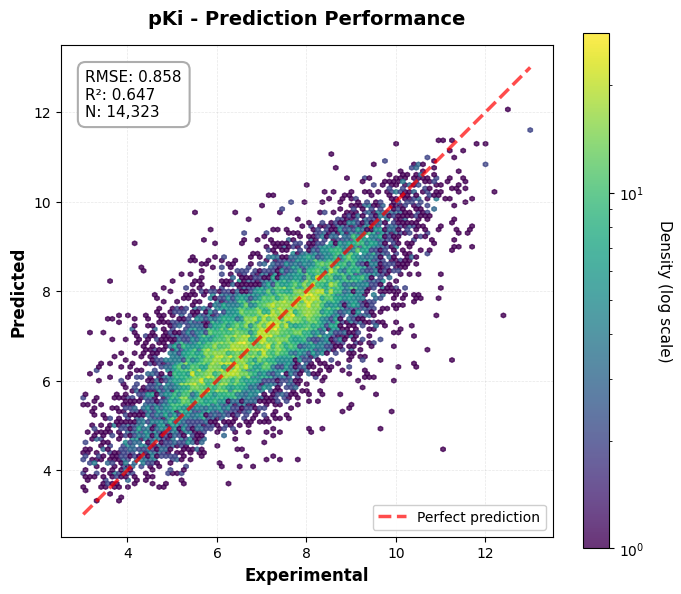

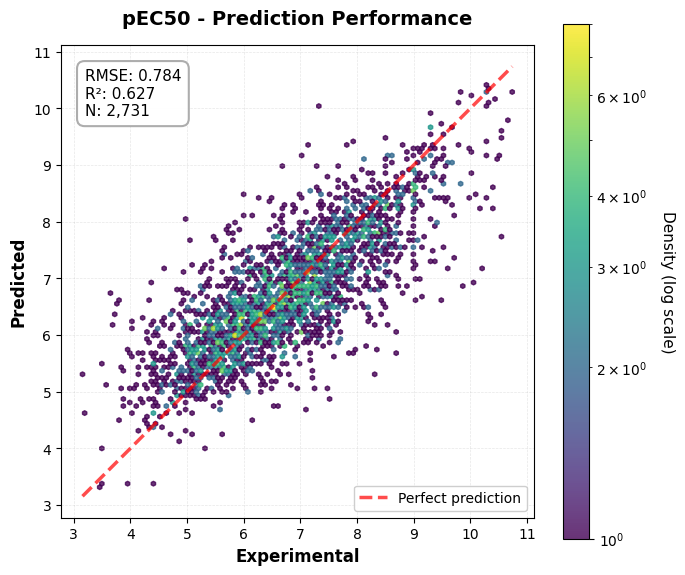

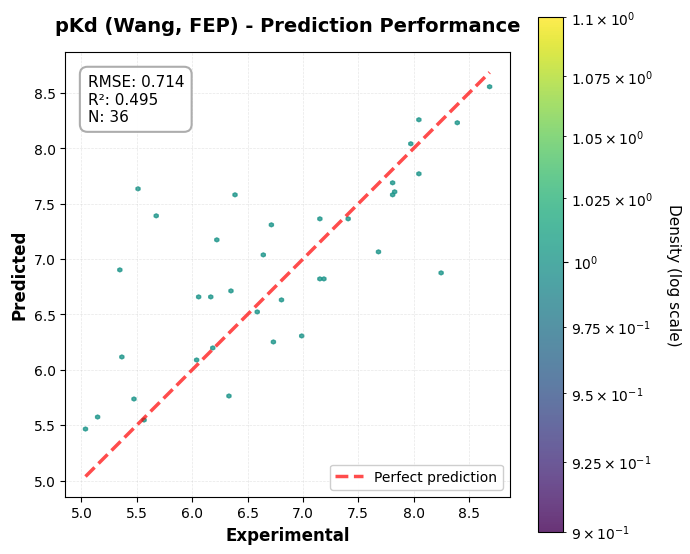

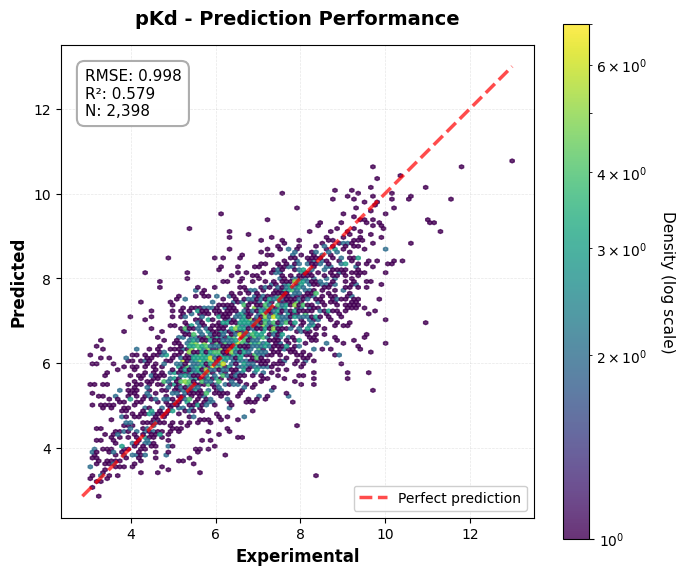

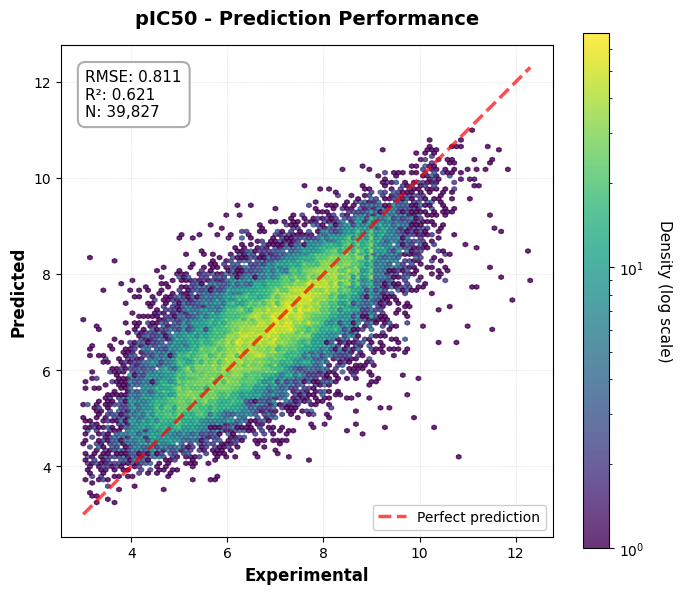

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

def plot_hexbin_predictions(df, save_path='hexbin_predictions.png', figsize=(15, 12)):
    """
    Create hexbin density plots for predicted vs experimental values for each task.
    
    Args:
        df: DataFrame with columns like 'taskname_exp' and 'taskname_pred'
        save_path: Path to save the figure
        figsize: Figure size tuple
    """
    
    # Identify task pairs (experimental and predicted columns)
    task_pairs = []
    for col in df.columns:
        if col.endswith('_exp'):
            task_name = col[:-4]  # Remove '_exp' suffix
            pred_col = f'{task_name}_pred'
            if pred_col in df.columns:
                task_pairs.append((task_name, col, pred_col))
    
    # Calculate number of subplot rows and columns
    n_tasks = len(task_pairs)
    n_cols = min(3, n_tasks)  # Maximum 3 columns
    n_rows = (n_tasks + n_cols - 1) // n_cols
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Flatten axes array for easier iteration
    if n_tasks == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    for idx, (task_name, exp_col, pred_col) in enumerate(task_pairs):
        ax = axes[idx]
        
        # Remove NaN values
        mask = ~(df[exp_col].isna() | df[pred_col].isna())
        exp_values = df[exp_col][mask].values
        pred_values = df[pred_col][mask].values
        
        if len(exp_values) > 0:
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(exp_values, pred_values))
            r2 = r2_score(exp_values, pred_values)
            n_samples = len(exp_values)
            
            # Create hexbin plot with log scale coloring
            hexbin = ax.hexbin(exp_values, pred_values, 
                               gridsize=25,
                               cmap='viridis',
                               norm=LogNorm(),
                               mincnt=1,
                               alpha=0.9,
                               edgecolors='face')
            
            # Add colorbar
            cbar = plt.colorbar(hexbin, ax=ax)
            cbar.set_label('Count (log scale)', rotation=270, labelpad=15)
            
            # Add diagonal reference line (perfect prediction)
            min_val = min(exp_values.min(), pred_values.min())
            max_val = max(exp_values.max(), pred_values.max())
            ax.plot([min_val, max_val], [min_val, max_val], 
                   'r--', lw=2, alpha=0.7, label='Perfect prediction')
            
            # Set labels and title
            ax.set_xlabel('Experimental', fontsize=11, fontweight='bold')
            ax.set_ylabel('Predicted', fontsize=11, fontweight='bold')
            ax.set_title(f'{task_name}', fontsize=13, fontweight='bold', pad=10)
            
            # Add metrics as text box
            metrics_text = f'RMSE: {rmse:.3f}\nR²: {r2:.3f}\nN: {n_samples}'
            ax.text(0.05, 0.95, metrics_text, 
                   transform=ax.transAxes,
                   fontsize=10,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', 
                            facecolor='white', 
                            alpha=0.9,
                            edgecolor='gray'))
            
            # Make the plot square
            ax.set_aspect('equal', adjustable='box')
            
            # Add grid
            ax.grid(True, alpha=0.3, linestyle='--')
            
        else:
            ax.text(0.5, 0.5, f'No data for {task_name}',
                   transform=ax.transAxes,
                   ha='center', va='center',
                   fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Remove empty subplots if any
    for idx in range(n_tasks, len(axes)):
        fig.delaxes(axes[idx])
    
    # Adjust layout
    plt.suptitle('Hexbin Density Plots: Predicted vs Experimental Values', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig


def create_individual_hexbin_plots(df, save_prefix='hexbin', dpi=600):
    """
    Create individual hexbin plots for each task.
    
    Args:
        df: DataFrame with columns like 'taskname_exp' and 'taskname_pred'
        save_prefix: Prefix for saved files
        dpi: DPI for saved figures
    """
    
    # Identify task pairs
    task_pairs = []
    for col in df.columns:
        if col.endswith('_exp'):
            task_name = col[:-4]
            pred_col = f'{task_name}_pred'
            if pred_col in df.columns:
                task_pairs.append((task_name, col, pred_col))
    
    for task_name, exp_col, pred_col in task_pairs:
        # Create individual figure
        fig, ax = plt.subplots(figsize=(7, 6))
        
        # Remove NaN values
        mask = ~(df[exp_col].isna() | df[pred_col].isna())
        exp_values = df[exp_col][mask].values
        pred_values = df[pred_col][mask].values
        
        if len(exp_values) > 0:
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(exp_values, pred_values))
            r2 = r2_score(exp_values, pred_values)
            n_samples = len(exp_values)
            
            # Create hexbin plot
            hexbin = ax.hexbin(exp_values, pred_values, 
                               gridsize=100,
                               cmap='viridis',
                               norm=LogNorm(),
                               mincnt=1,
                               alpha=0.8)
            
            # Add colorbar
            cbar = plt.colorbar(hexbin, ax=ax)
            cbar.set_label('Density (log scale)', rotation=270, labelpad=20, fontsize=11)
            
            # Add diagonal reference line
            min_val = min(exp_values.min(), pred_values.min())
            max_val = max(exp_values.max(), pred_values.max())
            ax.plot([min_val, max_val], [min_val, max_val], 
                   'r--', lw=2.5, alpha=0.7, label='Perfect prediction')
            
            # Set labels and title
            ax.set_xlabel('Experimental', fontsize=12, fontweight='bold')
            ax.set_ylabel('Predicted', fontsize=12, fontweight='bold')
            ax.set_title(f'{task_name} - Prediction Performance', 
                        fontsize=14, fontweight='bold', pad=15)
            
            # Add metrics
            metrics_text = f'RMSE: {rmse:.3f}\nR²: {r2:.3f}\nN: {n_samples:,}'
            ax.text(0.05, 0.95, metrics_text, 
                   transform=ax.transAxes,
                   fontsize=11,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.5', 
                            facecolor='white', 
                            alpha=0.95,
                            edgecolor='darkgray',
                            linewidth=1.5))
            
            # Make the plot square
            ax.set_aspect('equal', adjustable='box')
            
            # Add grid
            ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
            
            # Add legend
            ax.legend(loc='lower right', framealpha=0.95)
            
            plt.tight_layout()
            
            # Save individual plot
            safe_task_name = task_name.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '')
            plt.savefig(f'{save_prefix}_{safe_task_name}.png', dpi=dpi, bbox_inches='tight')
            plt.show()
            plt.close()


# Example usage
if __name__ == "__main__":
    # Sample data - replace with your actual DataFrame
        
    # Create individual plots
    create_individual_hexbin_plots(predictions_df, save_prefix='hexbin_individual')

In [39]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import json

def evaluate_checkpoint(checkpoint_path, model, test_loader, task_cols, device='cuda'):
    """
    Load a checkpoint and evaluate on test set.
    
    Returns:
        Dictionary with epoch, metrics per task
    """
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Collect predictions
    task_predictions = {task: [] for task in task_cols}
    task_targets = {task: [] for task in task_cols}
    
    with torch.no_grad():
        for batch in test_loader:
            xd = batch['drug'].to(device)
            xp = batch['protein'].to(device)
            y = batch['y'].to(device)
            
            pred = model(xd, xp)
            
            # Collect predictions per task
            for i, task in enumerate(task_cols):
                mask = ~torch.isnan(y[:, i])
                if mask.sum() > 0:
                    task_predictions[task].extend(pred[mask, i].cpu().numpy())
                    task_targets[task].extend(y[mask, i].cpu().numpy())
    
    # Calculate RMSE for each task
    results = {
        'epoch': checkpoint.get('epoch', None),
        'checkpoint_file': checkpoint_path.name
    }
    
    for task in task_cols:
        if len(task_predictions[task]) > 0:
            preds = np.array(task_predictions[task])
            targets = np.array(task_targets[task])
            rmse = np.sqrt(np.mean((preds - targets) ** 2))
            results[f'{task}_rmse'] = rmse
        else:
            results[f'{task}_rmse'] = np.nan
    
    return results


def test_all_checkpoints(
    checkpoint_dir,
    model,
    test_loader,
    task_cols,
    device='cuda',
    output_file='checkpoint_evaluation.csv'
):
    """
    Test all checkpoints in a directory and save results.
    
    Args:
        checkpoint_dir: Path to checkpoint directory
        model: Model instance (architecture only, weights will be loaded)
        test_loader: Test data loader
        task_cols: List of task column names
        device: Device to use
        output_file: Where to save results
    """
    checkpoint_dir = Path(checkpoint_dir)
    
    # Get all checkpoint files (excluding best_model.pt for now)
    checkpoint_files = sorted(
        [f for f in checkpoint_dir.glob('checkpoint_epoch_*.pt')],
        key=lambda x: int(x.stem.split('_')[-1])  # Sort by epoch number
    )
    
    # Also include best_model.pt
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        checkpoint_files.append(best_model_path)
    
    print(f"Found {len(checkpoint_files)} checkpoints to evaluate")
    
    results_list = []
    
    for checkpoint_path in tqdm(checkpoint_files, desc="Evaluating checkpoints"):
        try:
            results = evaluate_checkpoint(
                checkpoint_path,
                model,
                test_loader,
                task_cols,
                device
            )
            results_list.append(results)
            
            # Print progress
            epoch = results['epoch']
            print(f"\nEpoch {epoch}:")
            for task in task_cols:
                rmse = results.get(f'{task}_rmse', np.nan)
                if not np.isnan(rmse):
                    print(f"  {task}: RMSE = {rmse:.4f}")
            
        except Exception as e:
            print(f"\nError evaluating {checkpoint_path.name}: {e}")
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results_list)
    
    # Sort by epoch
    if 'epoch' in results_df.columns:
        results_df = results_df.sort_values('epoch')
    
    # Save to CSV
    results_df.to_csv(output_file, index=False)
    print(f"\n{'='*60}")
    print(f"Results saved to {output_file}")
    print(f"{'='*60}")
    
    # Find best checkpoint for each task
    print("\nBest checkpoint per task (by RMSE):")
    for task in task_cols:
        rmse_col = f'{task}_rmse'
        if rmse_col in results_df.columns:
            best_idx = results_df[rmse_col].idxmin()
            best_row = results_df.loc[best_idx]
            print(f"  {task}:")
            print(f"    Epoch: {best_row['epoch']}")
            print(f"    RMSE: {best_row[rmse_col]:.4f}")
            print(f"    File: {best_row['checkpoint_file']}")
    
    return results_df


# Usage:
checkpoint_dir = './checkpoints'

# Create model instance (same architecture as during training)
model_for_eval = MTL_DTAModel(
    task_names=CONFIG['task_cols'],
    **CONFIG['model_config']
).to(device)

# Run evaluation on all checkpoints
results_df = test_all_checkpoints(
    checkpoint_dir=checkpoint_dir,
    model=model_for_eval,
    test_loader=test_loader,
    task_cols=CONFIG['task_cols'],
    device=device,
    output_file='checkpoint_evaluation.csv'
)

# Display results
print("\nSummary statistics:")
print(results_df.describe())

# Plot results (optional)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, task in enumerate(CONFIG['task_cols']):
    if i < len(axes):
        ax = axes[i]
        rmse_col = f'{task}_rmse'
        if rmse_col in results_df.columns:
            ax.plot(results_df['epoch'], results_df[rmse_col], marker='o')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('RMSE')
            ax.set_title(f'{task}')
            ax.grid(True, alpha=0.3)
            
            # Mark best epoch(
            best_idx = results_df[rmse_col].idxmin()
            best_epoch = results_df.loc[best_idx, 'epoch']
            best_rmse = results_df.loc[best_idx, rmse_col]
            ax.axvline(best_epoch, color='red', linestyle='--', alpha=0.5)
            ax.plot(best_epoch, best_rmse, 'r*', markersize=15)

plt.tight_layout()
plt.savefig('checkpoint_rmse_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'checkpoint_rmse_comparison.png'")

Found 20 checkpoints to evaluate


Evaluating checkpoints:   5%|▌         | 1/20 [02:56<55:58, 176.74s/it]


Epoch 10:
  pKi: RMSE = 1.1418
  pEC50: RMSE = 1.0312
  pKd (Wang, FEP): RMSE = 0.8964
  pKd: RMSE = 1.2573
  pIC50: RMSE = 1.0754


Evaluating checkpoints:  10%|█         | 2/20 [05:42<51:01, 170.08s/it]


Epoch 20:
  pKi: RMSE = 1.0485
  pEC50: RMSE = 0.9521
  pKd (Wang, FEP): RMSE = 0.7493
  pKd: RMSE = 1.1711
  pIC50: RMSE = 0.9951


Evaluating checkpoints:  15%|█▌        | 3/20 [08:39<49:09, 173.52s/it]


Epoch 30:
  pKi: RMSE = 0.9978
  pEC50: RMSE = 0.9154
  pKd (Wang, FEP): RMSE = 0.8052
  pKd: RMSE = 1.1876
  pIC50: RMSE = 0.9456


Evaluating checkpoints:  20%|██        | 4/20 [11:39<46:56, 176.04s/it]


Epoch 40:
  pKi: RMSE = 0.9828
  pEC50: RMSE = 0.8896
  pKd (Wang, FEP): RMSE = 0.8048
  pKd: RMSE = 1.1342
  pIC50: RMSE = 0.9321


Evaluating checkpoints:  25%|██▌       | 5/20 [14:42<44:34, 178.32s/it]


Epoch 50:
  pKi: RMSE = 0.9507
  pEC50: RMSE = 0.8690
  pKd (Wang, FEP): RMSE = 0.7278
  pKd: RMSE = 1.0797
  pIC50: RMSE = 0.8977


Evaluating checkpoints:  30%|███       | 6/20 [17:55<42:46, 183.35s/it]


Epoch 60:
  pKi: RMSE = 0.9653
  pEC50: RMSE = 0.8790
  pKd (Wang, FEP): RMSE = 0.7769
  pKd: RMSE = 1.1269
  pIC50: RMSE = 0.9214


Evaluating checkpoints:  35%|███▌      | 7/20 [21:11<40:40, 187.71s/it]


Epoch 70:
  pKi: RMSE = 0.9276
  pEC50: RMSE = 0.8627
  pKd (Wang, FEP): RMSE = 0.7454
  pKd: RMSE = 1.0619
  pIC50: RMSE = 0.8879


Evaluating checkpoints:  40%|████      | 8/20 [25:10<40:45, 203.79s/it]


Epoch 80:
  pKi: RMSE = 0.9035
  pEC50: RMSE = 0.8269
  pKd (Wang, FEP): RMSE = 0.6792
  pKd: RMSE = 1.0589
  pIC50: RMSE = 0.8568


Evaluating checkpoints:  45%|████▌     | 9/20 [28:47<38:07, 207.95s/it]


Epoch 90:
  pKi: RMSE = 0.8930
  pEC50: RMSE = 0.8197
  pKd (Wang, FEP): RMSE = 0.7119
  pKd: RMSE = 1.0310
  pIC50: RMSE = 0.8457


Evaluating checkpoints:  50%|█████     | 10/20 [32:25<35:10, 211.04s/it]


Epoch 100:
  pKi: RMSE = 0.8934
  pEC50: RMSE = 0.8237
  pKd (Wang, FEP): RMSE = 0.7212
  pKd: RMSE = 1.0396
  pIC50: RMSE = 0.8420


Evaluating checkpoints:  55%|█████▌    | 11/20 [35:58<31:44, 211.63s/it]


Epoch 110:
  pKi: RMSE = 0.8810
  pEC50: RMSE = 0.8199
  pKd (Wang, FEP): RMSE = 0.7573
  pKd: RMSE = 1.0197
  pIC50: RMSE = 0.8423


Evaluating checkpoints:  60%|██████    | 12/20 [39:01<27:05, 203.14s/it]


Epoch 120:
  pKi: RMSE = 0.8837
  pEC50: RMSE = 0.8093
  pKd (Wang, FEP): RMSE = 0.6709
  pKd: RMSE = 1.0286
  pIC50: RMSE = 0.8371


Evaluating checkpoints:  65%|██████▌   | 13/20 [41:36<21:59, 188.45s/it]


Epoch 130:
  pKi: RMSE = 0.8769
  pEC50: RMSE = 0.8085
  pKd (Wang, FEP): RMSE = 0.6820
  pKd: RMSE = 1.0228
  pIC50: RMSE = 0.8288


Evaluating checkpoints:  75%|███████▌  | 15/20 [47:08<14:42, 176.47s/it]


Epoch 150:
  pKi: RMSE = 0.8858
  pEC50: RMSE = 0.8055
  pKd (Wang, FEP): RMSE = 0.6825
  pKd: RMSE = 1.0582
  pIC50: RMSE = 0.8387


Evaluating checkpoints:  80%|████████  | 16/20 [49:35<11:10, 167.66s/it]


Epoch 160:
  pKi: RMSE = 0.8608
  pEC50: RMSE = 0.7973
  pKd (Wang, FEP): RMSE = 0.7259
  pKd: RMSE = 1.0264
  pIC50: RMSE = 0.8169


Evaluating checkpoints:  85%|████████▌ | 17/20 [52:04<08:06, 162.18s/it]


Epoch 170:
  pKi: RMSE = 0.8608
  pEC50: RMSE = 0.7890
  pKd (Wang, FEP): RMSE = 0.7050
  pKd: RMSE = 1.0166
  pIC50: RMSE = 0.8109


Evaluating checkpoints:  90%|█████████ | 18/20 [55:00<05:32, 166.28s/it]


Epoch 180:
  pKi: RMSE = 0.8568
  pEC50: RMSE = 0.7875
  pKd (Wang, FEP): RMSE = 0.7353
  pKd: RMSE = 1.0211
  pIC50: RMSE = 0.8088


Evaluating checkpoints:  95%|█████████▌| 19/20 [57:49<02:47, 167.23s/it]


Epoch 190:
  pKi: RMSE = 1.2168
  pEC50: RMSE = 1.0709
  pKd (Wang, FEP): RMSE = 0.8540
  pKd: RMSE = 1.3259
  pIC50: RMSE = 1.1009


Evaluating checkpoints: 100%|██████████| 20/20 [1:00:15<00:00, 180.78s/it]


Epoch 171:
  pKi: RMSE = 0.8584
  pEC50: RMSE = 0.7843
  pKd (Wang, FEP): RMSE = 0.7140
  pKd: RMSE = 0.9983
  pIC50: RMSE = 0.8108

Results saved to checkpoint_evaluation.csv

Best checkpoint per task (by RMSE):
  pKi:
    Epoch: 180
    RMSE: 0.8568
    File: checkpoint_epoch_180.pt
  pEC50:
    Epoch: 171
    RMSE: 0.7843
    File: best_model.pt
  pKd (Wang, FEP):
    Epoch: 120
    RMSE: 0.6709
    File: checkpoint_epoch_120.pt
  pKd:
    Epoch: 171
    RMSE: 0.9983
    File: best_model.pt
  pIC50:
    Epoch: 180
    RMSE: 0.8088
    File: checkpoint_epoch_180.pt


KeyError: nan

In [ ]:
'1

In [38]:
# Evaluate on test set (for full training)
if 'test_loader' in locals():
    print("\nEvaluating on test set...")
    test_results = evaluate_model(model, test_loader, CONFIG['task_cols'], device)
    
    # Print test results
    print("\nTest Results:")
    for task, metrics in test_results.items():
        print(f"\n{task}:")
        for metric_name, value in metrics.items():
            if isinstance(value, float):
                print(f"  {metric_name}: {value:.4f}")
    
    # Save test results
    save_results(
        test_results,
        os.path.join(CONFIG['experiment_dir'], 'results', 'test_results.json'),
        format='json'
    )

# For cross-validation results
else:
    print("\nCross-Validation Summary:")
    summary_df = create_summary_report(
        cv_results,
        CONFIG['task_cols'],
        os.path.join(CONFIG['experiment_dir'], 'results', 'cv_summary.csv')
    )
    print(summary_df)


Evaluating on test set...


Evaluating: 100%|██████████| 616/616 [03:17<00:00,  3.12it/s]



Test Results:

pKi:
  rmse: 1.1317
  mae: 0.8984
  r2: 0.3901
  pearson_p: 0.0000
  spearman_r: 0.6153
  spearman_p: 0.0000
  mape: 0.1331
  c_index: 0.7208

pEC50:
  rmse: 1.0425
  mae: 0.8237
  r2: 0.3575
  pearson_p: 0.0000
  spearman_r: 0.6148
  spearman_p: 0.0000
  mape: 0.1245
  c_index: 0.7182

pKd (Wang, FEP):
  rmse: 0.7559
  mae: 0.6327
  r2: 0.4455
  pearson_p: 0.0000
  spearman_r: 0.6027
  spearman_p: 0.0000
  mape: 0.0917
  c_index: 0.7169

pKd:
  rmse: 1.2703
  mae: 1.0211
  r2: 0.2990
  pearson_p: 0.0000
  spearman_r: 0.5397
  spearman_p: 0.0000
  mape: 0.1713
  c_index: 0.6901

pIC50:
  rmse: 1.0269
  mae: 0.8153
  r2: 0.3907
  pearson_p: 0.0000
  spearman_r: 0.6152
  spearman_p: 0.0000
  mape: 0.1289
  c_index: 0.7199
Results saved to ../output/experiments/gnn_dta_mtl_experiment_20250930_072647/results/test_results.json


In [43]:
test_results

{'pKi': {'rmse': 1.1316651420320814,
  'mae': 0.8983533382415771,
  'r2': 0.3901151418685913,
  'pearson_r': 0.64164466,
  'pearson_p': 0.0,
  'spearman_r': 0.6153206834149614,
  'spearman_p': 0.0,
  'mape': 0.13312950730323792,
  'mean_true': 7.0294914,
  'mean_pred': 6.8226542,
  'std_true': 1.4490855,
  'std_pred': 0.87920344,
  'n_samples': 19024,
  'c_index': 0.7207845432931167},
 'pEC50': {'rmse': 1.0425318113454554,
  'mae': 0.8237210512161255,
  'r2': 0.35754626989364624,
  'pearson_r': 0.6272191,
  'pearson_p': 0.0,
  'spearman_r': 0.6147586637085726,
  'spearman_p': 0.0,
  'mape': 0.12451557070016861,
  'mean_true': 6.7500615,
  'mean_pred': 6.5045695,
  'std_true': 1.3006737,
  'std_pred': 0.79590863,
  'n_samples': 3692,
  'c_index': 0.7182186155041559},
 'pKd (Wang, FEP)': {'rmse': 0.7558923364199579,
  'mae': 0.63272625207901,
  'r2': 0.4454500675201416,
  'pearson_r': 0.7165361,
  'pearson_p': 1.6057309121583406e-09,
  'spearman_r': 0.6026933331425038,
  'spearman_p': 1.

# 7 : Visualization

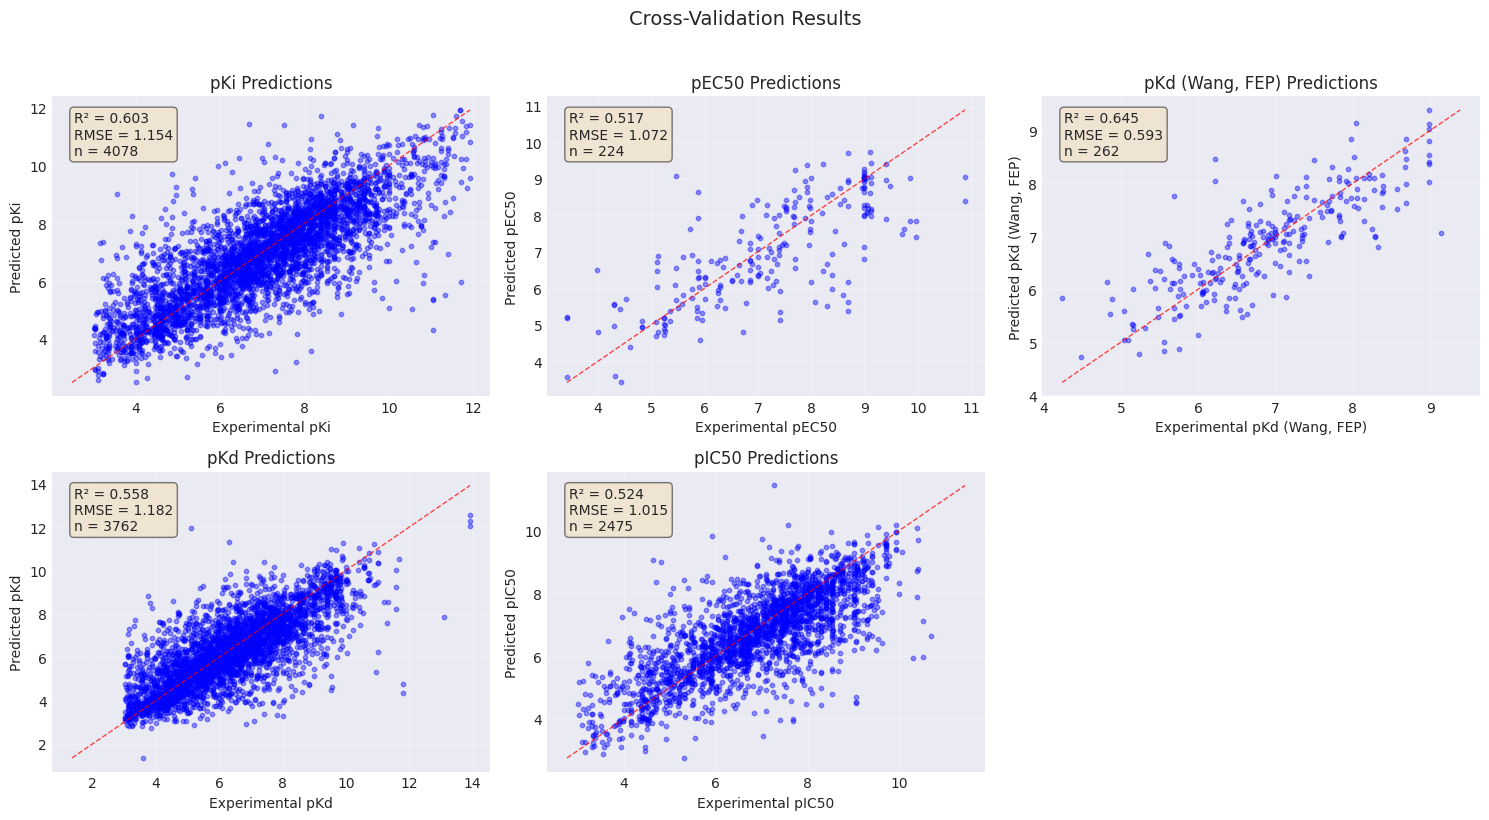

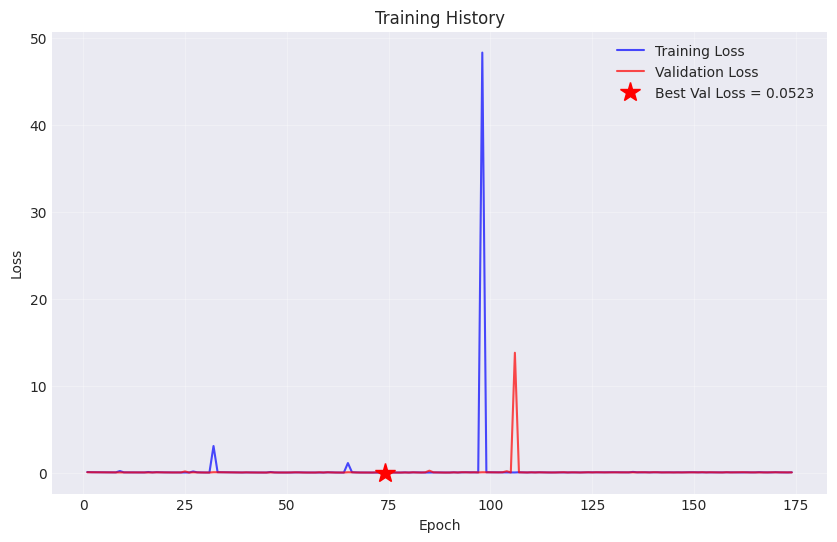

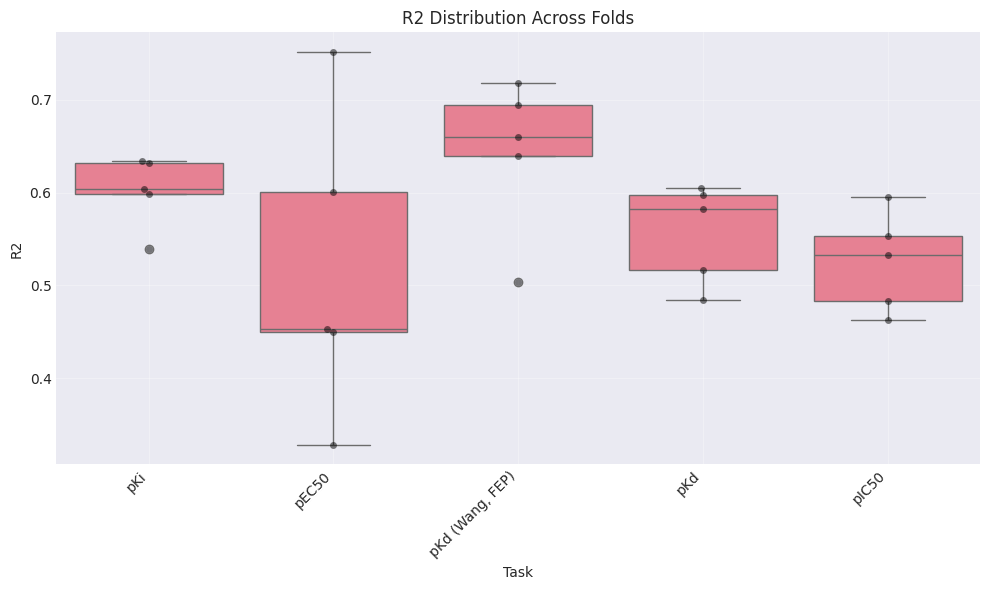

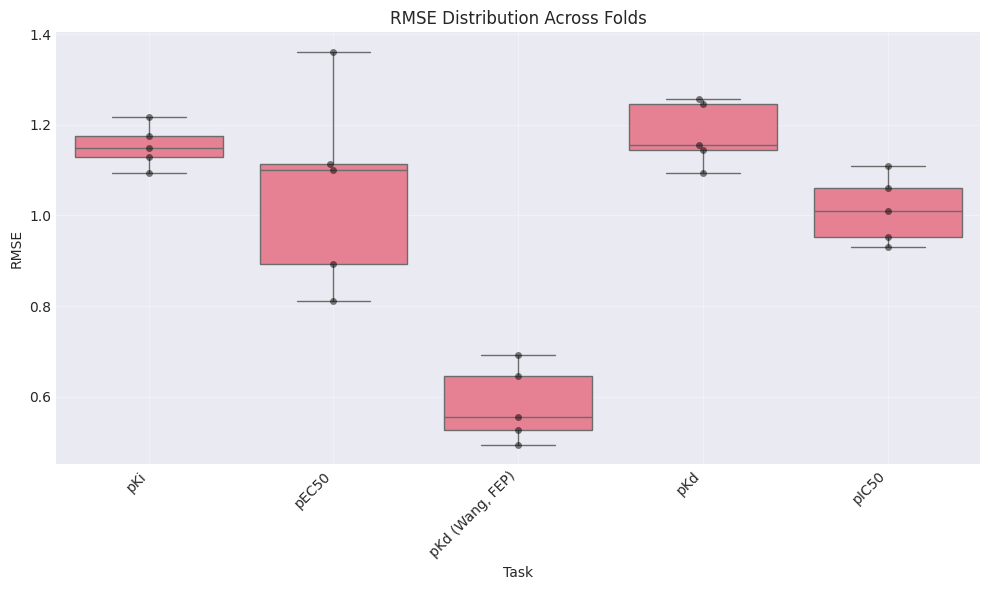

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Plot CV results
if 'cv_results' in locals():
    fig = plot_results(
        cv_results,
        CONFIG['task_cols'],
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'cv_results.png')
    )

# Plot training history
if 'trainer' in locals() and hasattr(trainer, 'train_losses'):
    from gnn_dta_mtl.evaluation.visualization import plot_training_history
    plot_training_history(
        trainer.train_losses,
        trainer.val_losses,
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'training_history.png')
    )

# Plot metrics distribution across folds
if 'cv_results' in locals():
    from gnn_dta_mtl.evaluation.visualization import plot_metrics_distribution
    plot_metrics_distribution(
        cv_results,
        CONFIG['task_cols'],
        metric='r2',
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'r2_distribution.png')
    )
    
    plot_metrics_distribution(
        cv_results,
        CONFIG['task_cols'],
        metric='rmse',
        save_path=os.path.join(CONFIG['experiment_dir'], 'figures', 'rmse_distribution.png')
    )

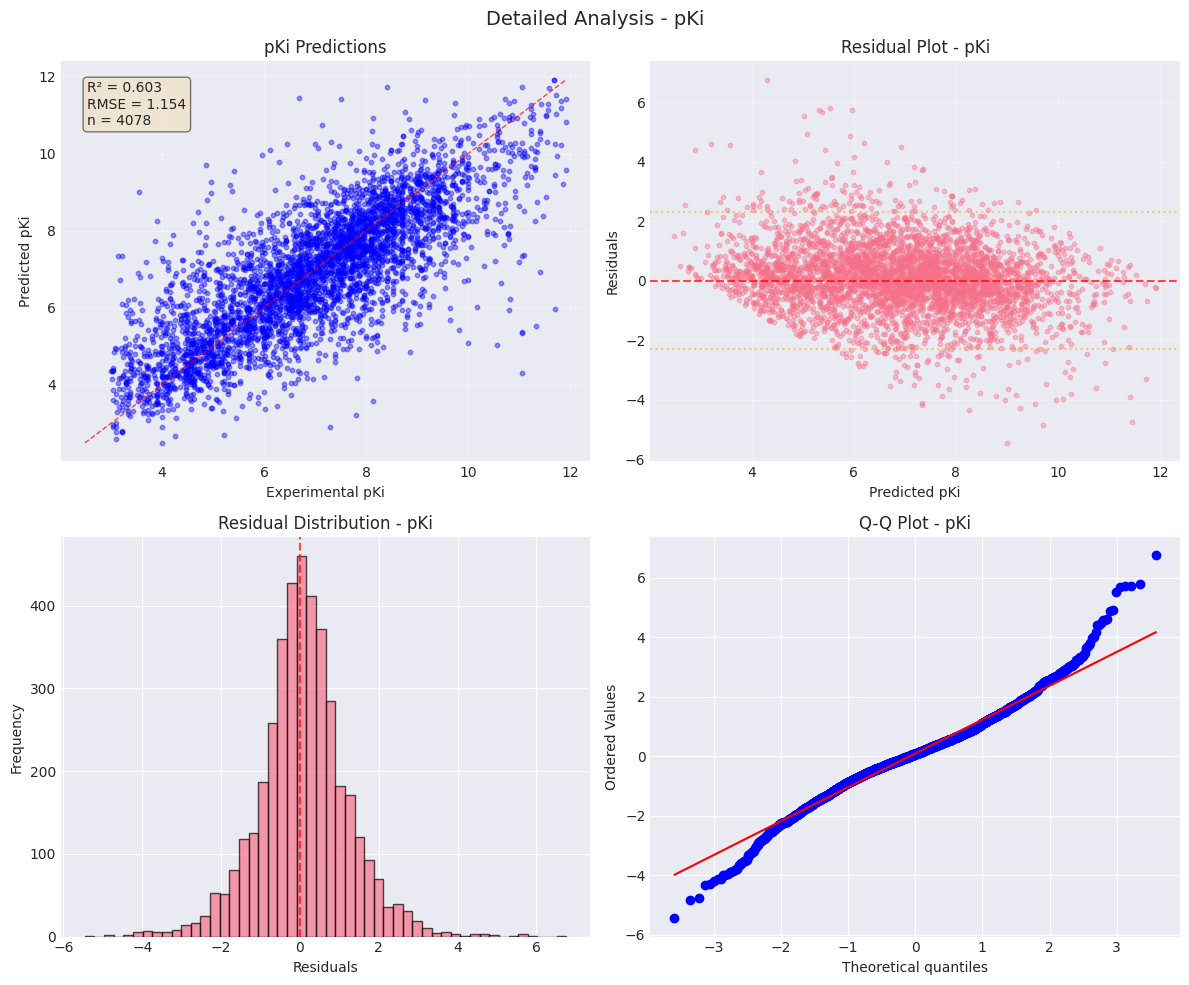

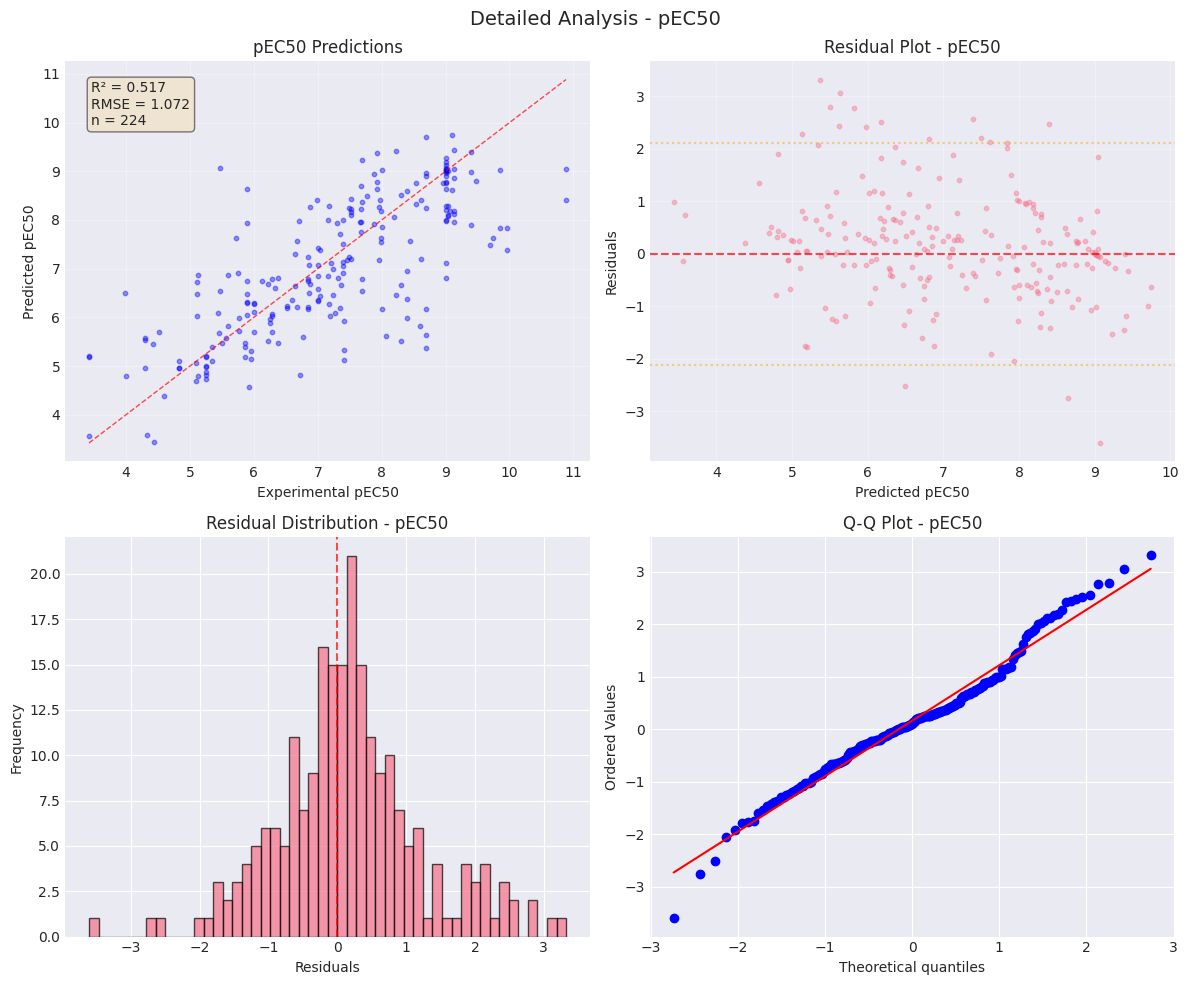

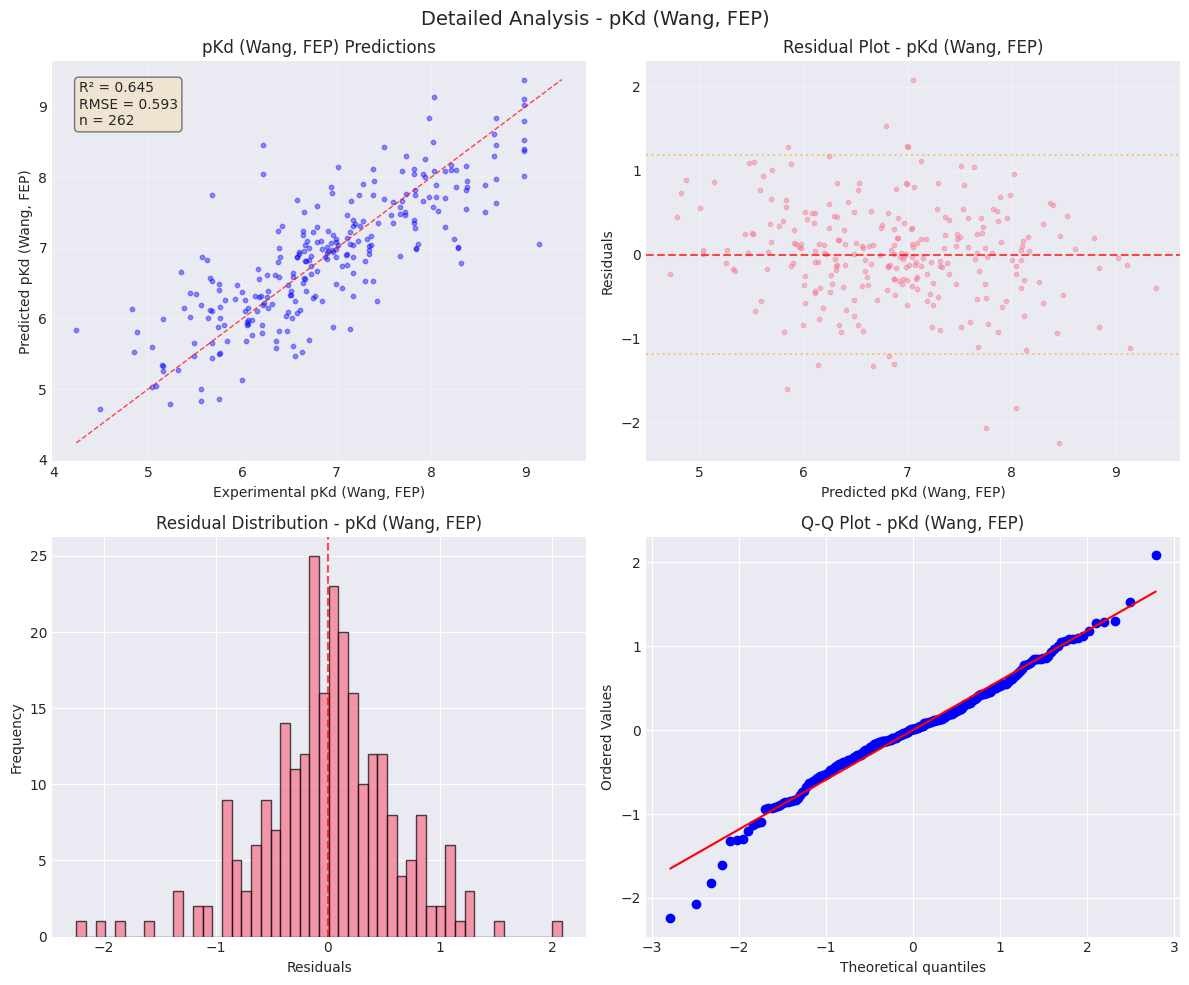

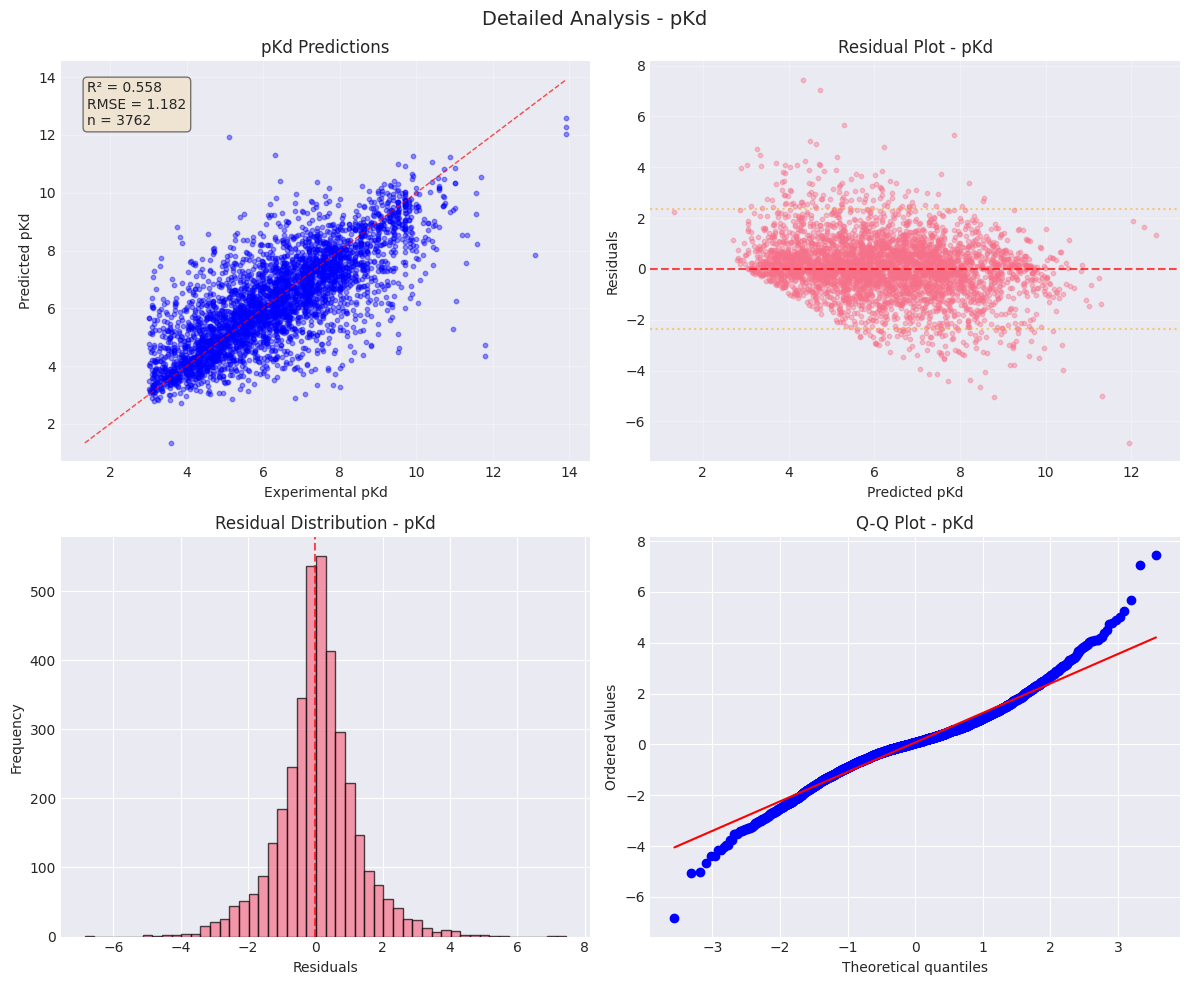

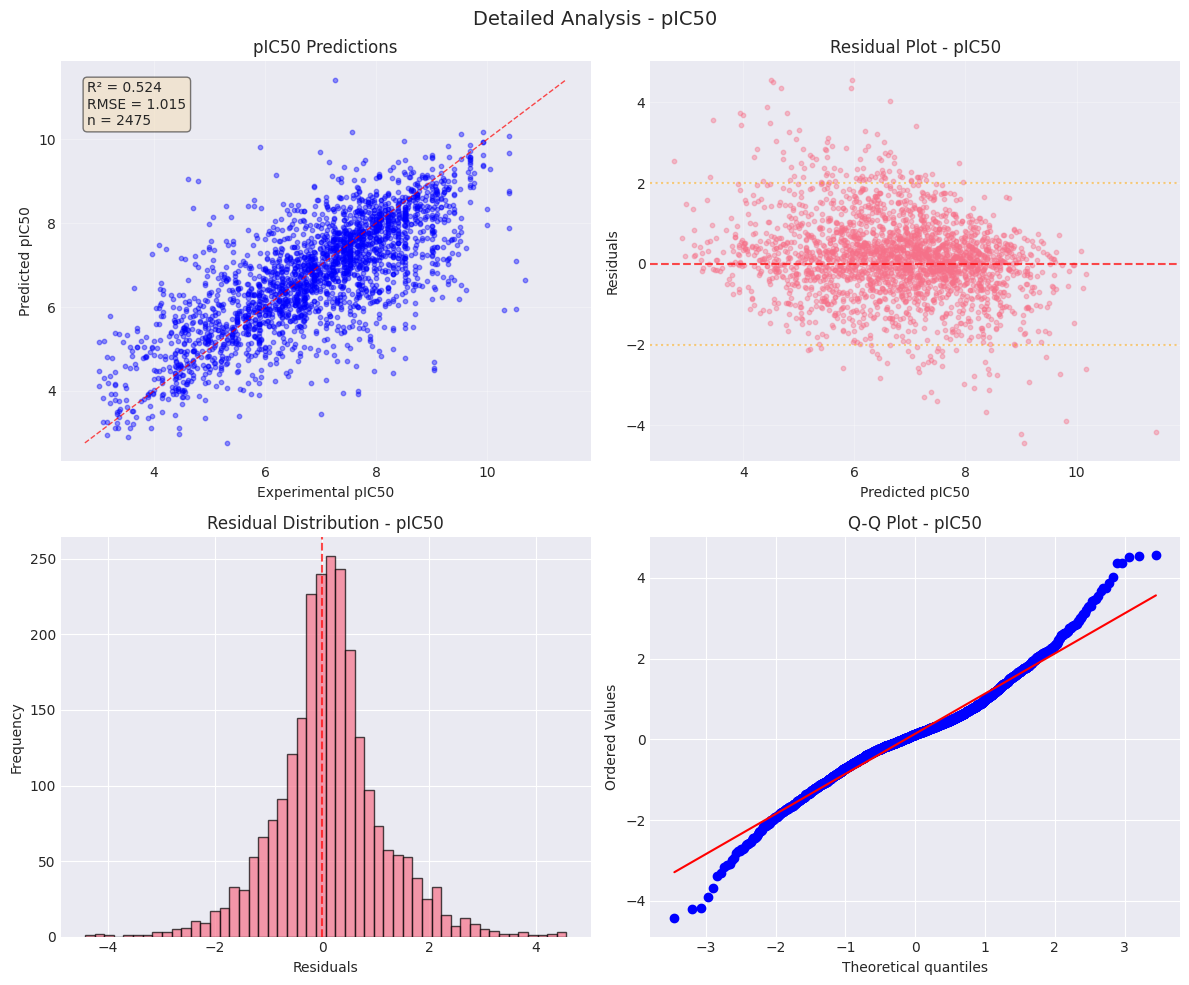

In [40]:
# Analyze prediction errors
if 'cv_results' in locals():
    for task in CONFIG['task_cols']:
        if len(cv_results[task]['all_targets']) > 0:
            targets = np.array(cv_results[task]['all_targets'])
            preds = np.array(cv_results[task]['all_predictions'])
            
            # Calculate residuals
            residuals = targets - preds
            
            # Create figure with subplots
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # 1. Predictions vs Targets
            ax = axes[0, 0]
            from gnn_dta_mtl.evaluation.visualization import plot_predictions
            plot_predictions(targets, preds, task, ax)
            
            # 2. Residuals plot
            ax = axes[0, 1]
            from gnn_dta_mtl.evaluation.visualization import plot_residuals
            plot_residuals(targets, preds, task, ax)
            
            # 3. Residual distribution
            ax = axes[1, 0]
            ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
            ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
            ax.set_xlabel('Residuals')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Residual Distribution - {task}')
            
            # 4. Q-Q plot
            ax = axes[1, 1]
            from scipy import stats
            stats.probplot(residuals, dist="norm", plot=ax)
            ax.set_title(f'Q-Q Plot - {task}')
            
            plt.suptitle(f'Detailed Analysis - {task}', fontsize=14)
            plt.tight_layout()
            plt.savefig(
                os.path.join(CONFIG['experiment_dir'], 'figures', f'analysis_{task}.png'),
                dpi=300, bbox_inches='tight'
            )
            plt.show()

In [41]:
# Cell 14: Bootstrap Analysis
from gnn_dta_mtl.evaluation.metrics import bootstrap_metrics

if 'cv_results' in locals():
    print("\nBootstrap Confidence Intervals (95%):")
    
    for task in CONFIG['task_cols']:
        if len(cv_results[task]['all_targets']) > 0:
            targets = np.array(cv_results[task]['all_targets'])
            preds = np.array(cv_results[task]['all_predictions'])
            
            # Calculate bootstrap CIs
            boot_results = bootstrap_metrics(
                targets, preds,
                n_bootstrap=1000,
                confidence=0.95,
                seed=SEED
            )
            
            print(f"\n{task}:")
            for metric, (mean, lower, upper) in boot_results.items():
                print(f"  {metric}: {mean:.3f} [{lower:.3f}, {upper:.3f}]")


Bootstrap Confidence Intervals (95%):

pKi:
  rmse: 1.154 [1.152, 1.155]
  r2: 0.603 [0.602, 0.603]
  mae: 0.847 [0.847, 0.848]

pEC50:
  rmse: 1.075 [1.071, 1.079]
  r2: 0.506 [0.502, 0.510]
  mae: 0.791 [0.788, 0.794]

pKd (Wang, FEP):
  rmse: 0.593 [0.591, 0.596]
  r2: 0.642 [0.639, 0.645]
  mae: 0.441 [0.439, 0.442]

pKd:
  rmse: 1.183 [1.181, 1.184]
  r2: 0.557 [0.556, 0.558]
  mae: 0.842 [0.841, 0.843]

pIC50:
  rmse: 1.015 [1.014, 1.016]
  r2: 0.523 [0.522, 0.524]
  mae: 0.735 [0.734, 0.736]


Model Statistics:
  Total parameters: 3,438,484
  Model size: 13.12 MB


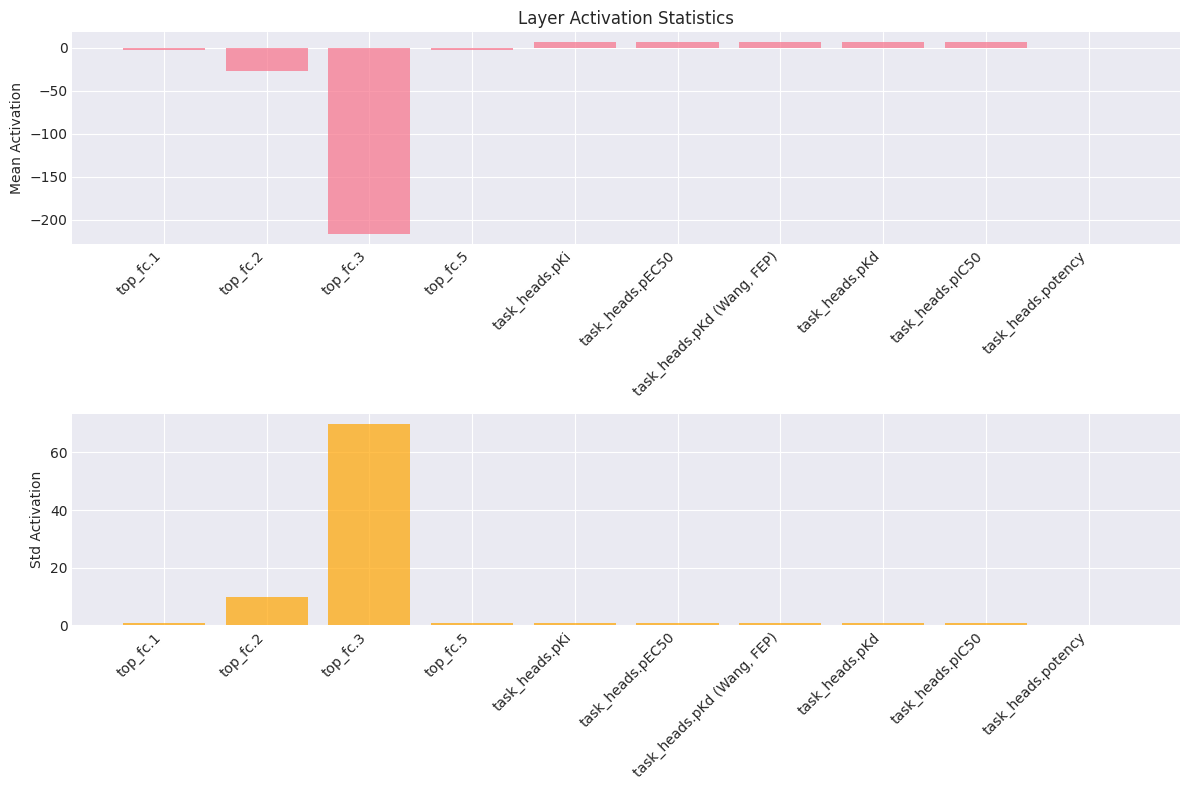

In [42]:
# Cell 15: Analyze Model Features
if 'model' in locals():
    from gnn_dta_mtl.utils.model_utils import (
        count_parameters, 
        get_model_size,
        get_activation_stats
    )
    
    # Model statistics
    n_params = count_parameters(model)
    model_size = get_model_size(model)
    
    print("Model Statistics:")
    print(f"  Total parameters: {n_params:,}")
    print(f"  Model size: {model_size['total_size_mb']:.2f} MB")
    
    # Get activation statistics
    if 'test_loader' in locals():
        act_stats = get_activation_stats(model, test_loader, device)
        
        # Visualize activation statistics
        layers = list(act_stats.keys())[-10:]  # Last 10 layers
        means = [act_stats[l]['mean'] for l in layers]
        stds = [act_stats[l]['std'] for l in layers]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        x = range(len(layers))
        ax1.bar(x, means, alpha=0.7)
        ax1.set_xticks(x)
        ax1.set_xticklabels(layers, rotation=45, ha='right')
        ax1.set_ylabel('Mean Activation')
        ax1.set_title('Layer Activation Statistics')
        
        ax2.bar(x, stds, alpha=0.7, color='orange')
        ax2.set_xticks(x)
        ax2.set_xticklabels(layers, rotation=45, ha='right')
        ax2.set_ylabel('Std Activation')
        
        plt.tight_layout()
        plt.savefig(
            os.path.join(CONFIG['experiment_dir'], 'figures', 'activation_stats.png'),
            dpi=300, bbox_inches='tight'
        )
        plt.show()

# Export


In [23]:
# Cell 16: Export Final Results
import json
from datetime import datetime

# Compile all results
final_results = {
    'experiment_name': experiment_name,
    'timestamp': datetime.now().isoformat(),
    'config': CONFIG,
    'data_stats': {
        'total_samples': len(df),
        'train_samples': len(df_train) if 'df_train' in locals() else None,
        'valid_samples': len(df_valid) if 'df_valid' in locals() else None,
        'test_samples': len(df_test) if 'df_test' in locals() else None
    }
}

# Add CV results summary
if 'cv' in locals() and hasattr(cv, 'summary'):
    final_results['cv_summary'] = cv.summary

# Add test results
if 'test_results' in locals():
    final_results['test_results'] = test_results

# Save comprehensive report
report_path = os.path.join(CONFIG['experiment_dir'], 'final_report.json')
with open(report_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\nFinal report saved to: {report_path}")
print(f"All results saved in: {CONFIG['experiment_dir']}")

# Create LaTeX table for publication
if 'cv' in locals() and hasattr(cv, 'summary'):
    print("\nLaTeX Table for Publication:")
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\begin{tabular}{lcccc}")
    print("\\hline")
    print("Task & R² & RMSE & MAE & N \\\\")
    print("\\hline")
    
    for task, metrics in cv.summary.items():
        print(f"{task} & "
              f"{metrics['r2_mean']:.3f}$\\pm${metrics['r2_std']:.3f} & "
              f"{metrics['rmse_mean']:.3f}$\\pm${metrics['rmse_std']:.3f} & "
              f"- & "
              f"{metrics['n_samples']} \\\\")
    
    print("\\hline")
    print("\\end{tabular}")
    print("\\caption{Cross-validation results for multi-task drug-target affinity prediction}")
    print("\\end{table}")


Final report saved to: ../output/experiments/gnn_dta_mtl_experiment_20250929_093711/final_report.json
All results saved in: ../output/experiments/gnn_dta_mtl_experiment_20250929_093711

LaTeX Table for Publication:
\begin{table}[h]
\centering
\begin{tabular}{lcccc}
\hline
Task & R² & RMSE & MAE & N \\
\hline
pKi & 0.601$\pm$0.034 & 1.153$\pm$0.042 & - & 4078 \\
pEC50 & 0.517$\pm$0.146 & 1.056$\pm$0.192 & - & 224 \\
pKd (Wang, FEP) & 0.643$\pm$0.075 & 0.583$\pm$0.074 & - & 262 \\
pKd & 0.557$\pm$0.048 & 1.179$\pm$0.063 & - & 3762 \\
pIC50 & 0.525$\pm$0.048 & 1.012$\pm$0.066 & - & 2475 \\
\hline
\end{tabular}
\caption{Cross-validation results for multi-task drug-target affinity prediction}
\end{table}


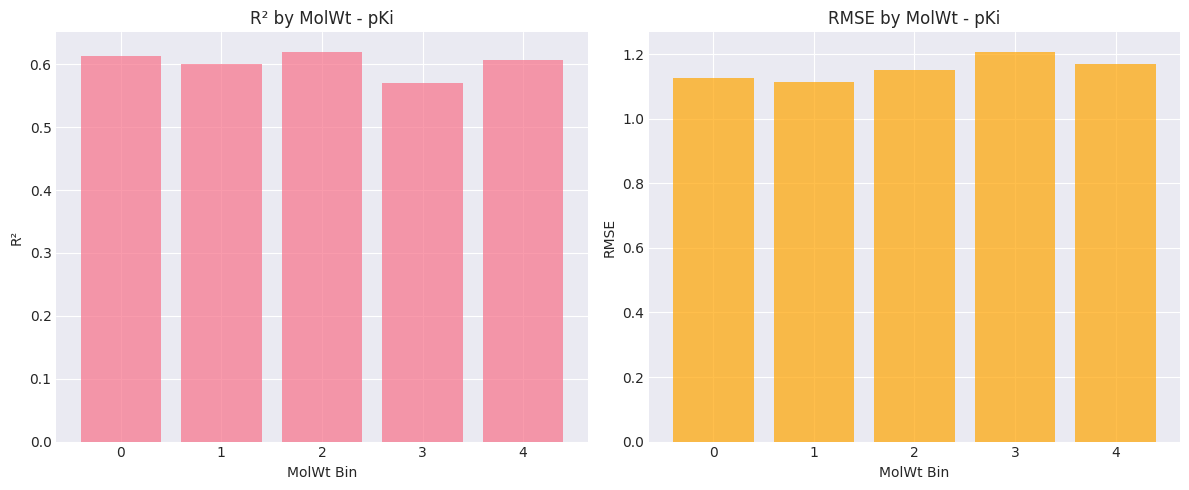

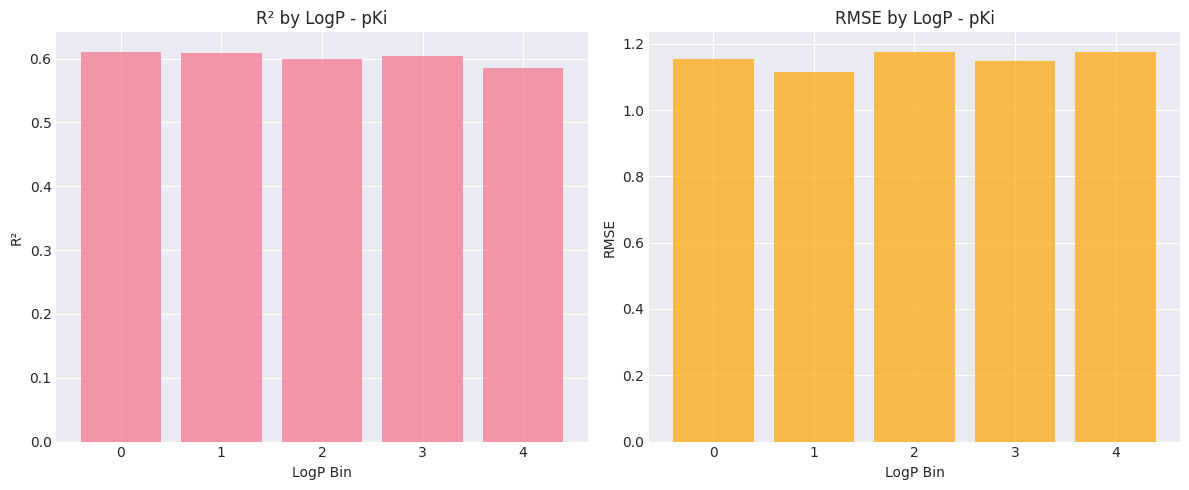

In [24]:
# Cell 17: Interactive Analysis Functions
def analyze_predictions_by_property(task, property_col='MolWt', n_bins=5):
    """Analyze predictions by molecular property"""
    if task not in cv_results or len(cv_results[task]['all_targets']) == 0:
        print(f"No results for {task}")
        return
    
    # Get predictions and targets
    targets = np.array(cv_results[task]['all_targets'])
    preds = np.array(cv_results[task]['all_predictions'])
    
    # Get property values (need to match with original df)
    # This assumes df is still aligned with cv_results
    property_values = df[property_col].values[:len(targets)]
    
    # Create bins
    bins = pd.qcut(property_values, n_bins, labels=False, duplicates='drop')
    
    # Calculate metrics per bin
    from sklearn.metrics import r2_score, mean_squared_error
    
    results = []
    for bin_idx in range(n_bins):
        mask = bins == bin_idx
        if mask.sum() > 0:
            r2 = r2_score(targets[mask], preds[mask])
            rmse = np.sqrt(mean_squared_error(targets[mask], preds[mask]))
            results.append({
                'bin': bin_idx,
                'n_samples': mask.sum(),
                'r2': r2,
                'rmse': rmse,
                f'{property_col}_mean': property_values[mask].mean()
            })
    
    results_df = pd.DataFrame(results)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.bar(results_df['bin'], results_df['r2'], alpha=0.7)
    ax1.set_xlabel(f'{property_col} Bin')
    ax1.set_ylabel('R²')
    ax1.set_title(f'R² by {property_col} - {task}')
    
    ax2.bar(results_df['bin'], results_df['rmse'], alpha=0.7, color='orange')
    ax2.set_xlabel(f'{property_col} Bin')
    ax2.set_ylabel('RMSE')
    ax2.set_title(f'RMSE by {property_col} - {task}')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Example usage
if 'cv_results' in locals():
    for task in CONFIG['task_cols'][:1]:  # Analyze first task
        results_by_mw = analyze_predictions_by_property(task, 'MolWt')
        results_by_logp = analyze_predictions_by_property(task, 'LogP')

In [25]:
# Cell 18: Save Session State
import pickle

# Save important objects
session_state = {
    'config': CONFIG,
    'task_ranges': task_ranges,
    'cv_results': cv_results if 'cv_results' in locals() else None,
    'test_results': test_results if 'test_results' in locals() else None,
    'df_stats': {
        'shape': df.shape,
        'columns': df.columns.tolist(),
        'task_coverage': {task: df[task].notna().sum() for task in CONFIG['task_cols']}
    }
}

session_path = os.path.join(CONFIG['experiment_dir'], 'session_state.pkl')
with open(session_path, 'wb') as f:
    pickle.dump(session_state, f)

print(f"Session state saved to: {session_path}")
print("\nTo restore session in a new notebook:")
print(f"with open('{session_path}', 'rb') as f:")
print("    session_state = pickle.load(f)")

Session state saved to: ../output/experiments/gnn_dta_mtl_experiment_20250929_093711/session_state.pkl

To restore session in a new notebook:
with open('../output/experiments/gnn_dta_mtl_experiment_20250929_093711/session_state.pkl', 'rb') as f:
    session_state = pickle.load(f)


In [ ]:
1